<a href="https://colab.research.google.com/github/SergeiVKalinin/Research-Projects/blob/main/DKL_hAE/Forensic_PFM_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable ML and Human in the Loop interventions for the Automated Experiment: Deep Kernel Learning for STEM-EELS

- Initial workflow build by Yongtao Liu, https://scholar.google.com/citations?hl=en&user=V9FMPgQAAAAJ
- Based on GPax library by Maxim Ziatdinov, https://scholar.google.com/citations?hl=en&user=YnSdOoUAAAAJ  
- Adapted for EELS by Kevin Roccapriore, https://scholar.google.com/citations?user=YnSdOoUAAAAJ
- Samples grown and prepared by Shin Hum Cho and Delia Milliron @ UT Austin
- Adapted by Sergei V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ

If you are interested in GP/BO for automated experiment, check GPax repository (https://github.com/ziatdinovmax/gpax) and add your stars!

The additional details (for Piezoresponse Microscopy) can be found at: https://arxiv.org/abs/2302.06577

This notebook summarizes the forensic analysis of the Deep Kernel Learning (DKL) based automated experiment in toy data. Forensic analysis is the first step towards the explainable automated experiment, and aims to explore and visualzie the experimental progression and the decision making made by the ML agent during the experiment. This is also a first step towards the human in the loop interventions.

The reason why this analysis is necessary can be illustarted by the figure below. Human operator works on microscope by issuing the commands (position the probe, initiate scan, initiate spectrum acquisition, start grid measurements) directly to the microscope. The AI agent works similarly to human operator, generating the list of commands in microsocpe specific hyper-language. However, we still need to understand and control (human in the loop) the ML agent. One way to do it is to intervene and issue the contorl commands (direct intervention). The other is to control the behavior (policies) of the ML agent, meaning dynamically tuning the reward function, exploration-exploitation policies, etc. of the ML agent. This in turn requires tools for monitoring the automated experiment. This notebook presents these developments.

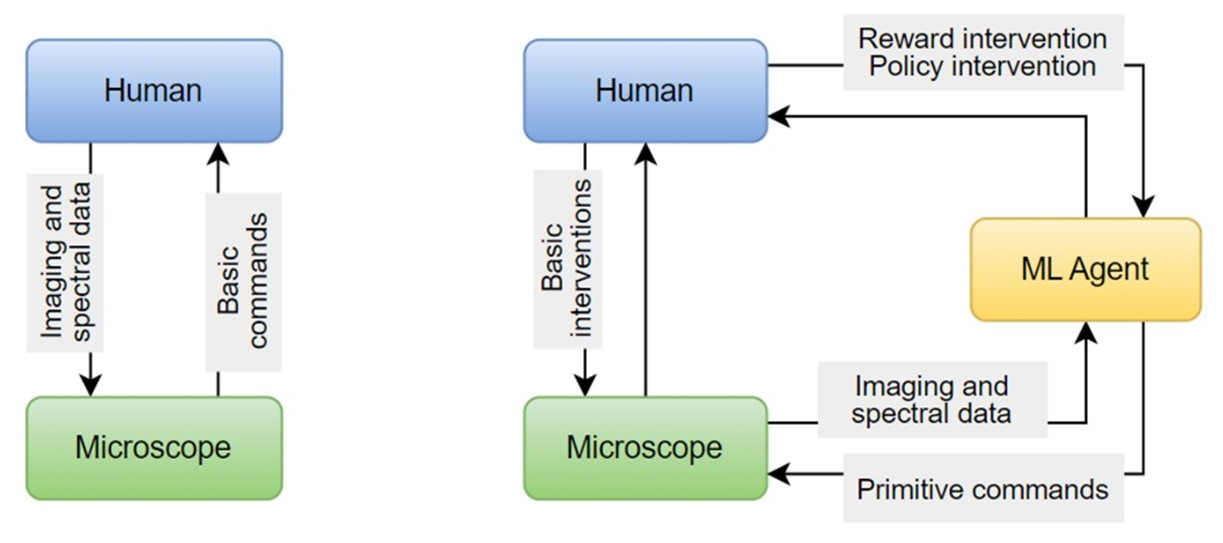

# **1. Import and download data**

In [ ]:
#@title
%%capture
!pip install -q git+https://github.com/pycroscopy/atomai.git
# !pip install atomai
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install lmfit
!pip install sidpy
!pip install bglib
!pip install -U gdown

In [ ]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import gpax
import numpyro
import jax
import jax.numpy as jnp
import math
import atomai as aoi
import torch
import os
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from lmfit.models import GaussianModel
import h5py
import sidpy

from atomai import utils
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

## Load helper functions

In [ ]:
#@title
# Load helper functions
from typing import Tuple

def make_window(imgsrc: np.ndarray, window_size: int,
                xpos: int, ypos: int) -> np.ndarray:
    """
    Returns the portion of the image within the window given the
    image (imgsrc), the x position and the y position
    """
    imgsrc = imgsrc[int(xpos-window_size/2):int(xpos+window_size/2),
                    int(ypos-window_size/2):int(ypos+window_size/2)]
    return imgsrc

def create_training_set(imgdata: np.ndarray, target: np.ndarray,
                        window_size: int) -> Tuple[np.ndarray]:
    """
    Creates arrays with features (local subimages)
    and targets (corresponding spectra) from hyperspectral data
    """
    feature_arr, target_arr = [], []
    pos = []
    s1, s2 = imgdata.shape[:-1]
    for i in range(s1):
        for j in range(s2):
            arr_loc = make_window(imgdata, window_size, i, j)
            if arr_loc.shape[:-1] != (window_size, window_size):
                continue
            feature_arr.append(arr_loc)
            target_arr.append(target[i, j])
            pos.append([i, j])
    return np.array(pos), np.array(feature_arr), np.array(target_arr)

from typing import Tuple, Optional, Dict, Union, List

def get_imgstack(imgdata: np.ndarray,
                 coord: np.ndarray,
                 r: int) -> Tuple[np.ndarray]:
    """
    Extracts subimages centered at specified coordinates
    for a single image
    Args:
        imgdata (3D numpy array):
            Prediction of a neural network with dimensions
            :math:`height \\times width \\times n channels`
        coord (N x 2 numpy array):
            (x, y) coordinates
        r (int):
            Window size
    Returns:
        2-element tuple containing
        - Stack of subimages
        - (x, y) coordinates of their centers
    """
    img_cr_all = []
    com = []
    for c in coord:
        cx = int(np.around(c[0]))
        cy = int(np.around(c[1]))
        if r % 2 != 0:
            img_cr = np.copy(
                imgdata[cx-r//2:cx+r//2+1,
                        cy-r//2:cy+r//2+1])
        else:
            img_cr = np.copy(
                imgdata[cx-r//2:cx+r//2,
                        cy-r//2:cy+r//2])
        if img_cr.shape[0:2] == (int(r), int(r)) and not np.isnan(img_cr).any():
            img_cr_all.append(img_cr[None, ...])
            com.append(c[None, ...])
    if len(img_cr_all) == 0:
        return None, None
    img_cr_all = np.concatenate(img_cr_all, axis=0)
    com = np.concatenate(com, axis=0)
    return img_cr_all, com


def extract_subimages(imgdata: np.ndarray,
                      coordinates: Union[Dict[int, np.ndarray], np.ndarray],
                      window_size: int, coord_class: int = 0) -> Tuple[np.ndarray]:

    if isinstance(coordinates, np.ndarray):
        coordinates = np.concatenate((
            coordinates, np.zeros((coordinates.shape[0], 1))), axis=-1)
        coordinates = {0: coordinates}
    if np.ndim(imgdata) == 2:
        imgdata = imgdata[None, ..., None]
    subimages_all, com_all, frames_all = [], [], []
    for i, (img, coord) in enumerate(
            zip(imgdata, coordinates.values())):
        coord_i = coord[np.where(coord[:, 2] == coord_class)][:, :2]
        stack_i, com_i = get_imgstack(img, coord_i, window_size)
        if stack_i is None:
            continue
        subimages_all.append(stack_i)
        com_all.append(com_i)
        frames_all.append(np.ones(len(com_i), int) * i)
    if len(subimages_all) > 0:
        subimages_all = np.concatenate(subimages_all, axis=0)
        com_all = np.concatenate(com_all, axis=0)
        frames_all = np.concatenate(frames_all, axis=0)

    return subimages_all, com_all, frames_all

def extract_patches_and_spectra(hdata: np.ndarray, *args: np.ndarray,
                                coordinates: np.ndarray = None,
                                window_size: int = None,
                                avg_pool: int = 2,
                                **kwargs: Union[int, List[int]]
                                ) -> Tuple[np.ndarray]:
    """
    Extracts image patches and associated spectra
    (corresponding to patch centers) from hyperspectral dataset
    Args:
        hdata:
            3D or 4D hyperspectral data
        *args:
            2D image for patch extraction. If not provided, then
            patches will be extracted from hyperspectral data
            averaged over a specified band (range of "slices")
        coordinates:
            2D numpy array with xy coordinates
        window_size:
            Image patch size
        avg_pool:
            Kernel size and stride for average pooling in spectral dimension(s)
        **band:
            Range of slices in hyperspectral data to average over
            for producing a 2D image if the latter is not provided as a separate
            argument. For 3D data, it can be integer (use a single slice)
            or a 2-element list. For 4D data, it can be integer or a 4-element list.
        Returns:
            3-element tuple with image patches, associated spectra and coordinates
    """
    F = torch.nn.functional
    if hdata.ndim not in (3, 4):
        raise ValueError("Hyperspectral data must 3D or 4D")
    if len(args) > 0:
        img = args[0]
        if img.ndim != 2:
            raise ValueError("Image data must be 2D")
    else:
        band = kwargs.get("band", 0)
        if hdata.ndim == 3:
            if isinstance(band, int):
                band = [band, band+1]
            img = hdata[..., band[0]:band[1]].mean(-1)
        else:
            if isinstance(band, int):
                band = [band, band+1, band, band+1]
            elif isinstance(band, list) and len(band) == 2:
                band = [*band, *band]
            img = hdata[..., band[0]:band[1], band[2]:band[3]].mean((-2, -1))
    patches, coords, _ = extract_subimages(img, coordinates, window_size)
    patches = patches.squeeze()
    spectra = []
    for c in coords:
        spectra.append(hdata[int(c[0]), int(c[1])])
    avg_pool = 2*[avg_pool] if (isinstance(avg_pool, int) & hdata.ndim == 4) else avg_pool
    torch_pool = F.avg_pool1d if hdata.ndim == 3 else F.avg_pool2d
    spectra = torch.tensor(spectra).cpu().unsqueeze(1)
    spectra = torch_pool(spectra, avg_pool, avg_pool).squeeze().numpy()
    return patches, spectra, coords

In [ ]:
#@title
# DKL specific functions

def plot_dkl(full_img, window_size, y,
             dkl_mean, dkl_var):

    plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(1,3,width_ratios = [1,1,1])
    ax00,ax01,ax02 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2])

    s1, s2 = full_img.shape[0] - window_size+1, full_img.shape[1] - window_size+1

    if y.ndim == 1:   # Scalar DKL
        original    = y.reshape(s1,s2)
        predicted   = dkl_mean.reshape(s1,s2)
        uncertainty = dkl_var.reshape(s1,s2)

    elif y.ndim == 2: # Vector DKL
        original    = np.swapaxes(y.reshape(-1,s1,s2).T, 0, 1)
        predicted   = np.swapaxes(dkl_mean.reshape(-1,s1,s2).T, 0, 1)
        uncertainty = np.swapaxes(dkl_var.reshape(-1,s1,s2).T, 0, 1)

    ax00.imshow(original)
    ax01.imshow(predicted)
    ax02.imshow(uncertainty)

    ax00.set_title("original")
    ax01.set_title("mean (prediction)")
    ax02.set_title("variance (uncertainty)")

    if y.ndim == 2: # we can show individual spectra. Otherwise, we've already scalarized it

        rng = np.random.default_rng()
        xx_ = rng.choice(s1, 3, replace = False)
        yy_ = rng.choice(s2, 3, replace = False)
        XY = np.asarray([xx_,yy_]).T

        x1,y1 = XY[0]
        x2,y2 = XY[1]
        x3,y3 = XY[2]

        ax00.scatter(x1,y1, c='dodgerblue', ec='k', s=100)
        ax00.scatter(x2,y2, c='darkorange', ec='k', s=100)
        ax00.scatter(x3,y3, c='crimson', ec='k', s=100)

        plt.figure(figsize=(10,5))
        ax = plt.gca()

        ax.plot(original[y1,x1], c='dodgerblue', lw = 2, ls ='--')
        ax.plot(original[y2,x2], c='darkorange', lw = 2, ls ='--')
        ax.plot(original[y3,x3], c='crimson', lw = 2, ls ='--')

        ax.plot(predicted[y1,x1], c='dodgerblue', lw = 2)
        ax.plot(predicted[y2,x2], c='darkorange', lw = 2)
        ax.plot(predicted[y3,x3], c='crimson', lw = 2)

        ax.axhline(0, c='k')
        ax.set_xlabel("Energy loss (eV)", fontsize = 22)
        ax.tick_params(length=5, width=3, labelsize = 18)

from typing import Union

def EI(model: aoi.models.dklGPR, X: Union[np.ndarray, torch.Tensor],
       best_f: Union[float, torch.Tensor], xi: float = 0.01) -> np.ndarray:
    """
    Expected Improvement
    """
    device=model.device
    dtype = model.dtype
    X = torch.from_numpy(X) if isinstance(X, np.ndarray) else X
    best_f = torch.from_numpy(best_f) if isinstance(best_f, float) else best_f
    posterior = model._compute_posterior(X.to(dtype).to(device))
    samples = posterior.rsample(torch.Size([1000, ]))
    mean, sigma = samples.mean(0), samples.var(0).sqrt()
    u = (mean - best_f.expand_as(mean) - xi) / sigma
    normal = torch.distributions.Normal(torch.zeros_like(u), torch.ones_like(u))
    ucdf = normal.cdf(u)
    updf = torch.exp(normal.log_prob(u))
    obj = sigma * (updf + u * ucdf)
    return obj.detach().cpu().numpy()


def qEI(model: aoi.models.dklGPR, X: Union[np.ndarray, torch.Tensor],
        best_f: Union[float, torch.Tensor], xi: float = 0.01,
        **kwargs: int) -> np.ndarray:
    """
    MC-based Expected Improvement
    """
    device = model.device
    dtype = model.dtype
    sampler = botorch.sampling.SobolQMCNormalSampler(500, kwargs.get("seed", 42))
    X = torch.from_numpy(X) if isinstance(X, np.ndarray) else X
    best_f = torch.from_numpy(best_f) if isinstance(best_f, float) else best_f
    posterior = model.gp_model.posterior(X.to(dtype).to(device))
    samples = sampler(posterior)
    objective = botorch.acquisition.IdentityMCObjective()
    obj = objective(samples)
    obj = (obj - best_f.unsqueeze(-1).to(obj) - xi).clamp_min(0).detach().cpu()
    return obj.numpy()

def UCB(model: aoi.models.dklGPR, X: Union[np.ndarray, torch.Tensor],
        beta: float = 0.2) -> np.ndarray:
    """
    Upper confidence bound
    """
    device = model.device
    dtype = model.dtype
    X = torch.from_numpy(X) if isinstance(X, np.ndarray) else X
    beta = torch.tensor(beta) if isinstance(beta, float) else beta
    posterior = model._compute_posterior(X.to(dtype).to(device))
    samples = posterior.rsample(torch.Size([1000, ]))
    mean, var = samples.mean(0), samples.var(0)
    delta = (beta.expand_as(mean).to(dtype).to(device) * var).sqrt()
    return (mean + delta).detach().cpu().numpy()

def qUCB(model: aoi.models.dklGPR, X: Union[np.ndarray, torch.Tensor],
         beta: float = 0.2, **kwargs: int) -> np.ndarray:
    """
    MC-based upper confidence bound
    """
    device = model.device
    dtype = model.dtype
    X = torch.from_numpy(X) if isinstance(X, np.ndarray) else X
    beta_prime = math.sqrt(beta * math.pi / 2)
    posterior = model.gp_model.posterior(X.to(dtype).to(device))
    sampler = botorch.sampling.SobolQMCNormalSampler(500, kwargs.get("seed", 42))
    samples = sampler(posterior)
    objective = botorch.acquisition.IdentityMCObjective()
    obj = objective(samples)
    mean = obj.mean(dim=0)
    obj = mean + beta_prime * (obj - mean).abs()
    return obj.detach().cpu().numpy()


# Functions for plotting result, selecting next measurement point, and update train/test dataset
def sel_next_point (dklgp, X_train, X_test, xi):
  '''
  Function selects next_point_idx based on either EI
  acquision function (0) or maximum uncertainty point (1)
  '''
  global acq_idx
  if acq_idx == 0:  # 0 uses EI function
    best_f = torch.tensor(dklgp.predict(X_train)[0].max(), device=dklgp.device)
    obj = EI(dklgp, X_test, best_f, xi)
    next_point_idx = obj.mean(0).argmax()
  elif acq_idx == 1:  # 1 explores the max uncertainty point
    mean0, var0 = dklgp.predict(X_test, batch_size=len(X_test))
    next_point_idx = var0.argmax()
  elif acq_idx == 2:  # 2 uses UCB function
    obj = UCB(dklgp, X_test)
    next_point_idx = obj.mean(0).argmax()

  return next_point_idx

def update_train_test_data(X_train, X_test, y_train, y_test,
                           indices_train, indices_test,
                           next_point_idx, measured_point, next_point):
  X_train = np.append(X_train, X_test[next_point_idx][None], 0)
  X_test = np.delete(X_test, next_point_idx, 0)
  y_train = np.append(y_train, measured_point)
  y_test = np.delete(y_test, next_point_idx)
  indices_train = np.append(indices_train, next_point[None], 0)
  indices_test = np.delete(indices_test, next_point_idx, 0)

  return (X_train, X_test, y_train, y_test, indices_train, indices_test)



# Define a function to run DKL exploration
def dkl_explore (save_explore, num_cycles = 200):
  global X, y, indices_all, ts, rs, rf, acq_funcs, exploration_steps, acq_idx, ws
  # Here X_train and y_train are our measured image patches and spectra information,
  # whereas X_test and y_test are the "unknown" ones. The indices_train are grid coordinates of the measured points,
  # whereas the indices_test are the grid coordinates of the remaining available points on the grid
  (X_train, X_test, y_train, y_test,
   indices_train, indices_test) = train_test_split(
       X, y, indices_all, test_size=ts, shuffle=True, random_state=rs)
  print('X_train shape: '); print(X_train.shape)
  data_dim = X_train.shape[-1]

  if not os.path.exists(rf + acq_funcs[acq_idx] + save_explore):
    os.mkdir(rf + acq_funcs[acq_idx] + save_explore)
  os.chdir(rf + acq_funcs[acq_idx] + save_explore)
  np.savez("initial_traindata.npz", X_train = X_train, X_test = X_test, y_train = y_train,
           y_test = y_test, indices_train = indices_train, indices_test = indices_test)

  for e in range(exploration_steps):
    clear_output()
    print("{}/{}".format(e+1, exploration_steps))
    # Update GP posterior
    dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
    dklgp.fit(X_train, y_train, training_cycles=num_cycles)

    mean, var = dklgp.predict(X, batch_size=len(X))
    # plot_dkl_result(y, mean, var, indices=indices_train,
    #                 ws = ws, scatter_location = True)

    plot_dkl_result(y, mean, var)
    # Compute acquisition function
    next_point_idx = sel_next_point (dklgp, X_train, X_test, xi)
    next_point = indices_test[next_point_idx]

    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result

    # Update train and test datasets
    (X_train, X_test, y_train, y_test, indices_train,
     indices_test) = update_train_test_data(X_train, X_test, y_train, y_test,
                                            indices_train, indices_test,
                                            next_point_idx, measured_point, next_point)

    # Save result
    np.savez("record{}.npz".format(e),
             mean = mean, var = var, next_point_idx = next_point_idx,
             next_point = next_point, measured_point = measured_point)
  # Save final traindata
  np.savez("final_traindata.npz", X_train = X_train, X_test = X_test,
           y_train = y_train, y_test = y_test,
           indices_train = indices_train, indices_test = indices_test)

def dkl_counterfactual(y, save_counter, num_cycles = 200):
  global X, indices_all, ts, rs, rf, acq_funcs, exploration_steps, acq_idx, ws
  # Initialize train/test datasets
  (X_train, X_test, y_train, y_test,
   indices_train, indices_test) = train_test_split(
       X, y, indices_all, test_size=ts, shuffle=True, random_state=rs)

  # Set path for saving result
  if not os.path.exists(rf + acq_funcs[acq_idx] + save_counter):
    os.mkdir(rf + acq_funcs[acq_idx] + save_counter)

  # Save initial train data
  os.chdir(rf + acq_funcs[acq_idx] + save_counter)
  np.savez("initial_traindata.npz", X_train = X_train, X_test = X_test,
           y_train = y_train, y_test = y_test,
           indices_train = indices_train, indices_test = indices_test)

  # Start DKL analysis
  for e in range(exploration_steps):
    clear_output()
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
    dklgp.fit(X_train, y_train, training_cycles=num_cycles, lr = 0.01)

    mean, var = dklgp.predict(X, batch_size=len(X))
    # plot_dkl_result(y, mean, var, indices=indices_train,
    #                 ws = ws, scatter_location = True)
    plot_dkl_result(y, mean, var)

    #########################################################
    #################### Critical step ######################
    #########################################################

    # Load measurement locations from Step 1
    os.chdir(rf + acq_funcs[acq_idx] + save_explore)
    rec = np.load("record{}.npz".format(e))
    next_point_idx = rec['next_point_idx']
    next_point = indices_test[next_point_idx]
    #########################################################
    #########################################################

    # Do "measurement"
    measured_point = y_test[next_point_idx]

    # Update train and test datasets
    (X_train, X_test, y_train, y_test, indices_train,
     indices_test) = update_train_test_data(X_train, X_test, y_train, y_test,
                                            indices_train, indices_test,
                                            next_point_idx, measured_point, next_point)

    # Save result
    os.chdir(rf + acq_funcs[acq_idx] + save_counter)
    np.savez("record{}.npz".format(e),
             mean = mean, var = var, next_point_idx = next_point_idx,
             next_point = next_point, measured_point = measured_point)

  # Save final traindata
  os.chdir(rf + acq_funcs[acq_idx] + save_counter)
  np.savez("final_traindata.npz", X_train = X_train, X_test = X_test,
           y_train = y_train, y_test = y_test,
           indices_train = indices_train, indices_test = indices_test)


# Define a function to run dkl analysis with random sampling
def dkl_random(y, save_random, num_cycles = 200):
  global X, indices_all, ts, rs, rf, acq_funcs, exploration_steps, acq_idx, ws
  # Initialize train/test datasets
  (X_train, X_test, y_train, y_test,
   indices_train, indices_test) = train_test_split(
       X, y, indices_all, test_size=ts, shuffle=True, random_state=rs)

  # Set path for saving result
  if not os.path.exists(rf + acq_funcs[acq_idx] + save_random):
    os.mkdir(rf + acq_funcs[acq_idx] + save_random)

  # Save initial train data
  os.chdir(rf + acq_funcs[acq_idx] + save_random)
  np.savez("initial_traindata.npz", X_train = X_train, X_test = X_test,
           y_train = y_train, y_test = y_test,
           indices_train = indices_train, indices_test = indices_test)

  # Start DKL analysis
  for e in range(exploration_steps):
    clear_output()
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
    dklgp.fit(X_train, y_train, training_cycles=num_cycles, lr = 0.01)

    mean, var = dklgp.predict(X, batch_size=len(X))
    # plot_dkl_result(y, mean, var, indices=indices_train,
    #                 ws = ws, scatter_location = True)
    plot_dkl_result(y, mean, var)

    #########################################################
    #################### Critical step ######################
    #########################################################
    next_point_idx = np.random.randint(len(X_test))
    next_point = indices_test[next_point_idx]
    #########################################################
    #########################################################

    # Do "measurement"
    measured_point = y_test[next_point_idx]

    # Update train and test datasets
    (X_train, X_test, y_train, y_test, indices_train,
     indices_test) = update_train_test_data(X_train, X_test, y_train, y_test,
                                            indices_train, indices_test,
                                            next_point_idx, measured_point, next_point)

    # Save result
    os.chdir(rf + acq_funcs[acq_idx] + save_random)
    np.savez("record{}.npz".format(e),
             mean = mean, var = var, next_point_idx = next_point_idx,
             next_point = next_point, measured_point = measured_point)

  # Save final traindata
  os.chdir(rf + acq_funcs[acq_idx] + save_random)
  np.savez("final_traindata.npz", X_train = X_train, X_test = X_test,
           y_train = y_train, y_test = y_test,
           indices_train = indices_train, indices_test = indices_test)

# Define a function to run dkl counterfactual with different scalarizer
def dkl_mature_full(y, save_mature_full, num_cycles = 200):
  global X, indices_all, ts, rs, rf, acq_funcs, exploration_steps, acq_idx, ws

  # Load last step train dataset
  os.chdir(rf + acq_funcs[acq_idx] + save_explore)
  rec = np.load("final_traindata.npz")
  X_train = rec["X_train"]
  y_train = rec["y_train"]

  # Train a matured DKL model with the last step train dataset
  # dklgp0 will be the matured DKL model
  dklgp0 = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
  dklgp0.fit(X_train, y_train, training_cycles=num_cycles)

  # Train a full-informed DKL model with all data
  # dklgp1 will be the full-informed DKL model
  dklgp1 = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
  dklgp1.fit(X, y, training_cycles=num_cycles)

  # Initialize train/test datasets
  (X_train, X_test, y_train, y_test,
   indices_train, indices_test) = train_test_split(
       X, y, indices_all, test_size=ts, shuffle=True, random_state=rs)

  # Set path for saving result
  if not os.path.exists(rf + acq_funcs[acq_idx] + save_mature_full):
    os.mkdir(rf + acq_funcs[acq_idx] + save_mature_full)

  # Start DKL analysis
  for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    #update GP posterior
    dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
    dklgp.fit(X_train, y_train, training_cycles=num_cycles, lr = 0.01)

    mean, var = dklgp.predict(X_test, batch_size=len(X_test))  #real-time DKL model
    mean0, var0 = dklgp0.predict(X_test, batch_size=len(X_test)) #matured DKL model
    mean1, var1 = dklgp1.predict(X_test, batch_size=len(X_test)) #full-informed DKL model

    # Load measurement location from Step 1
    os.chdir(rf + acq_funcs[acq_idx] + save_explore)
    rec = np.load("record{}.npz".format(e))
    next_point_idx = rec['next_point_idx']
    next_point = indices_test[next_point_idx]

    # Do "measurement"
    measured_point = y_test[next_point_idx]

        # Save result
    os.chdir(rf + acq_funcs[acq_idx] + save_mature_full)
    np.savez("record{}.npz".format(e), y_test = y_test,
             mean = mean, var = var,
             mean0 = mean0, var0 = var0,
             mean1 = mean1, var1 = var1)

    # Update train and test datasets
    (X_train, X_test, y_train, y_test, indices_train,
     indices_test) = update_train_test_data(X_train, X_test, y_train, y_test,
                                            indices_train, indices_test,
                                            next_point_idx, measured_point, next_point = next_point)


## Download PFM data

In [ ]:
!gdown https://drive.google.com/uc?id=1-j7_YZwhHwjABXrFsLeWc4hhhShjf7Zr

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-j7_YZwhHwjABXrFsLeWc4hhhShjf7Zr
From (redirected): https://drive.google.com/uc?id=1-j7_YZwhHwjABXrFsLeWc4hhhShjf7Zr&confirm=t&uuid=e3b65cc6-ac20-45e0-9c7f-d6a8a652f932
To: /content/BEPFM_volt05V_train_0005.h5
100% 129M/129M [00:01<00:00, 108MB/s]


In [ ]:
input_file = "/content/BEPFM_volt05V_train_0005.h5"
h5_file = h5py.File(input_file, 'r+')
sidpy.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Raw_Data-SHO_Fit_001
      --------------------
      ├ Fit
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ completed_fit_positions
      ├ completed_guess_positions
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
  ├ Channel_001
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spe

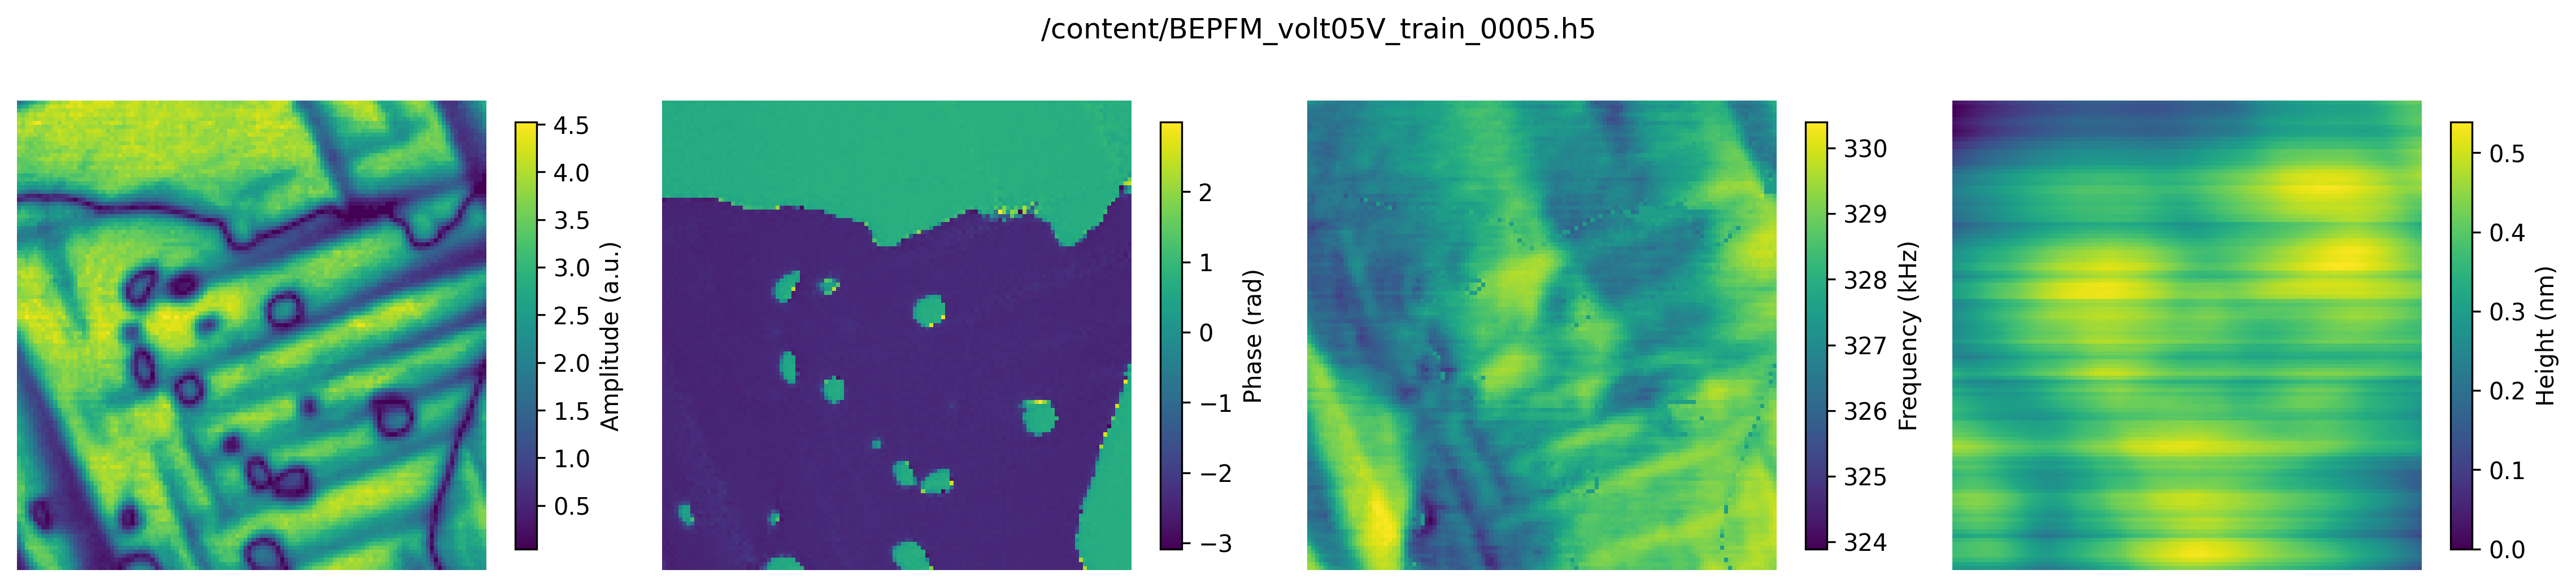

In [ ]:
rz = 256 # set the size of dataset
topo = h5_file['Measurement_000/Channel_001/Raw_Data']['r'].reshape(rz,rz)[60:-80, 60:-80]
amp = h5_file['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit']['Amplitude [V]'].reshape(rz,rz)[60:-80, 60:-80]
pha = h5_file['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit']['Phase [rad]'].reshape(rz,rz)[60:-80, 60:-80]
fre = h5_file['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit']['Frequency [Hz]'].reshape(rz,rz)[60:-80, 60:-80]
q = h5_file['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit']['Quality Factor'].reshape(rz,rz)[60:-80, 60:-80]

fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi = 300)
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.96, wspace=0.1)
fig.suptitle (input_file)
cm = 'viridis'
shrink = 0.7

im1 = axs[0].imshow(amp*10e3, interpolation='nearest', cmap=cm)
fig.colorbar(im1, ax=axs[0], shrink = shrink, label = "Amplitude (a.u.)")
axs[0].axis('off')

im2 = axs[1].imshow(pha, interpolation='nearest', cmap=cm)
fig.colorbar(im2, ax=axs[1], shrink = shrink, label = "Phase (rad)")
axs[1].axis('off')

im3 = axs[2].imshow(fre/1000, interpolation='nearest', cmap=cm)
fig.colorbar(im3, ax=axs[2], shrink = shrink, label = "Frequency (kHz)")
axs[2].axis('off')

im4 = axs[3].imshow((topo-topo.min())*10, interpolation='nearest', cmap=cm)
fig.colorbar(im4, ax=axs[3], shrink = shrink, label = "Height (nm)")
axs[3].axis('off')

plt.show()

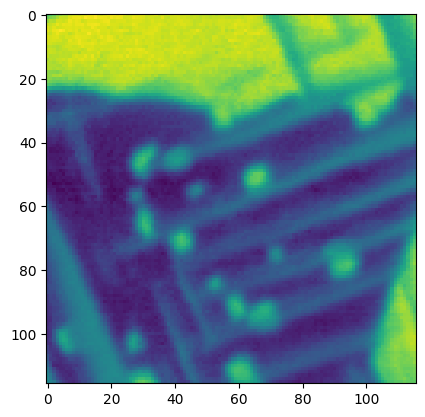

In [ ]:
pola = amp*np.cos(pha)
plt.imshow(pola)

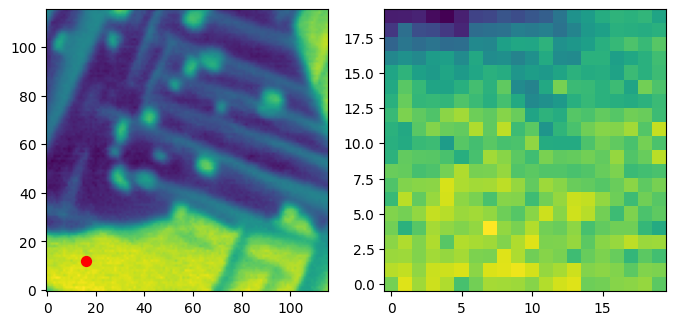

In [ ]:
#normalize
norm_ = lambda x: (x - x.min()) / (x.max() - x.min())
patch_image = norm_(pola) #normalize amplitude

# extract subimage for each point on a grid
coordinates = utils.get_coord_grid(patch_image, 1)   #grid

ws = 20  #patch window size
pix = int(len(patch_image)+1-ws)  #total pixel number

features_all, indices_all, _ = utils.extract_subimages(patch_image, coordinates, ws)
features_all = features_all[:,:,:,0]

# Show example patch and whole image
k = 200 # index
_, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(patch_image, origin = 'lower')
ax1.scatter(indices_all[k, 1], indices_all[k, 0], c = 'r', s = 50)
ax2.imshow(features_all[k], origin = 'lower')

In [ ]:
amp = norm_(amp)
pha = norm_(pha)
fre = norm_(fre)

In [ ]:
# Extract target scalarizers corresponding to patches
amp_all = np.zeros(pix*pix)
pha_all = np.zeros(pix*pix)
fre_all = np.zeros(pix*pix)

for i in range (pix*pix):
  amp_all [i] = amp[int(indices_all[i,0]), int(indices_all[i,1])]
  pha_all [i] = pha[int(indices_all[i,0]), int(indices_all[i,1])]
  fre_all [i] = fre[int(indices_all[i,0]), int(indices_all[i,1])]

amp_all = amp_all.reshape(-1)

Prepare train dataset

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)  #training input: image patches

y_targ = amp_all.reshape(-1)     #training output
y_targ = (y_targ-y_targ.min())/(y_targ.max()-y_targ.min())

y = y_targ.reshape(-1)
X.shape, y.shape

((9409, 400), (9409,))

# **3. DKL on full data (complete model)**

As a first step, let's initialize and train DKL-GPR model on the **<font color = 'dodgerblue'>FULL</font>** dataset. This is impossible for AE, but it creates a **complete** model - trained on all the data that can be obtained from this region. We can use this full model to check how fast the **live** (real time) model works.

Here, we introduce three definitions:
- **Live model**: the actual model that is being trained during the experiment
- **Final model**: the model available in the end of experiment
- **Complete model**: model that is trained if full data is availabel (i.e. via grid measurement)

## Full DKL with 2 embedding dimensions

In [ ]:
data_dim = X.shape[-1]

dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
dklgp.fit(X, y, training_cycles=30)

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Epoch 1/30 ... Training loss: 0.7703
Epoch 10/30 ... Training loss: 0.7129
Epoch 20/30 ... Training loss: 0.6775
Epoch 30/30 ... Training loss: 0.6345


Let's fit the model to data. Note that we already are starting to see interesting things - for example, for Spectrum 9 we see regions where variance is high - suggesting that something interesting is going on

In [ ]:
#@title Function for plotting DKL prediction and uncertainty
def plot_dkl_result (ground_truth, dkl_mean,
                     dkl_var, indices=None, ws=None,
                     scatter_location = False):
  '''
  Function plots DKL prediction and uncertainty.
  Setting scatter_location = True and providing indices_train
  and window_size enable plotting training data points in ground
  truth.
  '''

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))

  cm = 'viridis'
  shrink = 0.7
  pix = int(math.sqrt(len(dkl_mean)))

  im1 = ax1.imshow(ground_truth.reshape(pix,pix), interpolation='nearest', origin = "lower", cmap=cm)
  fig.colorbar(im1, ax=ax1, shrink = shrink)
  if scatter_location == True:
    ax1.scatter(indices[:, 1]-int(ws/2), indices[:, 0]-int(ws/2), s=12,
                c = np.arange(len(indices)), cmap = 'bwr')
  ax1.set_title("Ground Truth")
  ax1.axis('off')

  im2 = ax2.imshow(dkl_mean.reshape(pix,pix), interpolation='nearest', origin = "lower", cmap=cm)
  fig.colorbar(im2, ax=ax2, shrink = shrink)
  ax2.set_title("DKL Prediction")
  ax2.axis('off')

  im3 = ax3.imshow(dkl_var.reshape(pix,pix), interpolation='nearest', origin = "lower", cmap=cm)
  fig.colorbar(im3, ax=ax3, shrink = shrink)
  ax3.set_title("DKL Uncertainty")
  ax3.axis('off')

  plt.show()
  plt.close(fig)

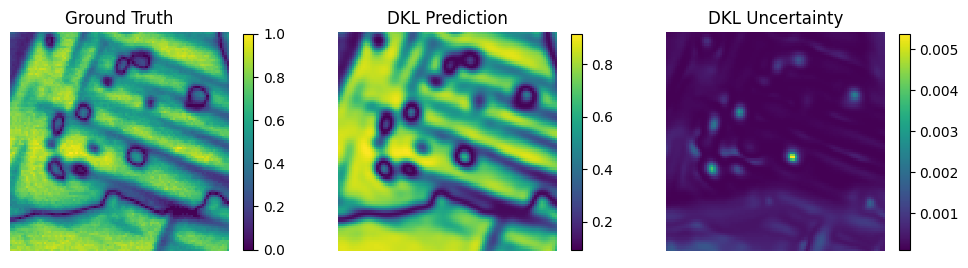

In [ ]:
mean, var = dklgp.predict(X, batch_size=len(X))
plot_dkl_result(y, mean, var)

And visualize the latent variables.

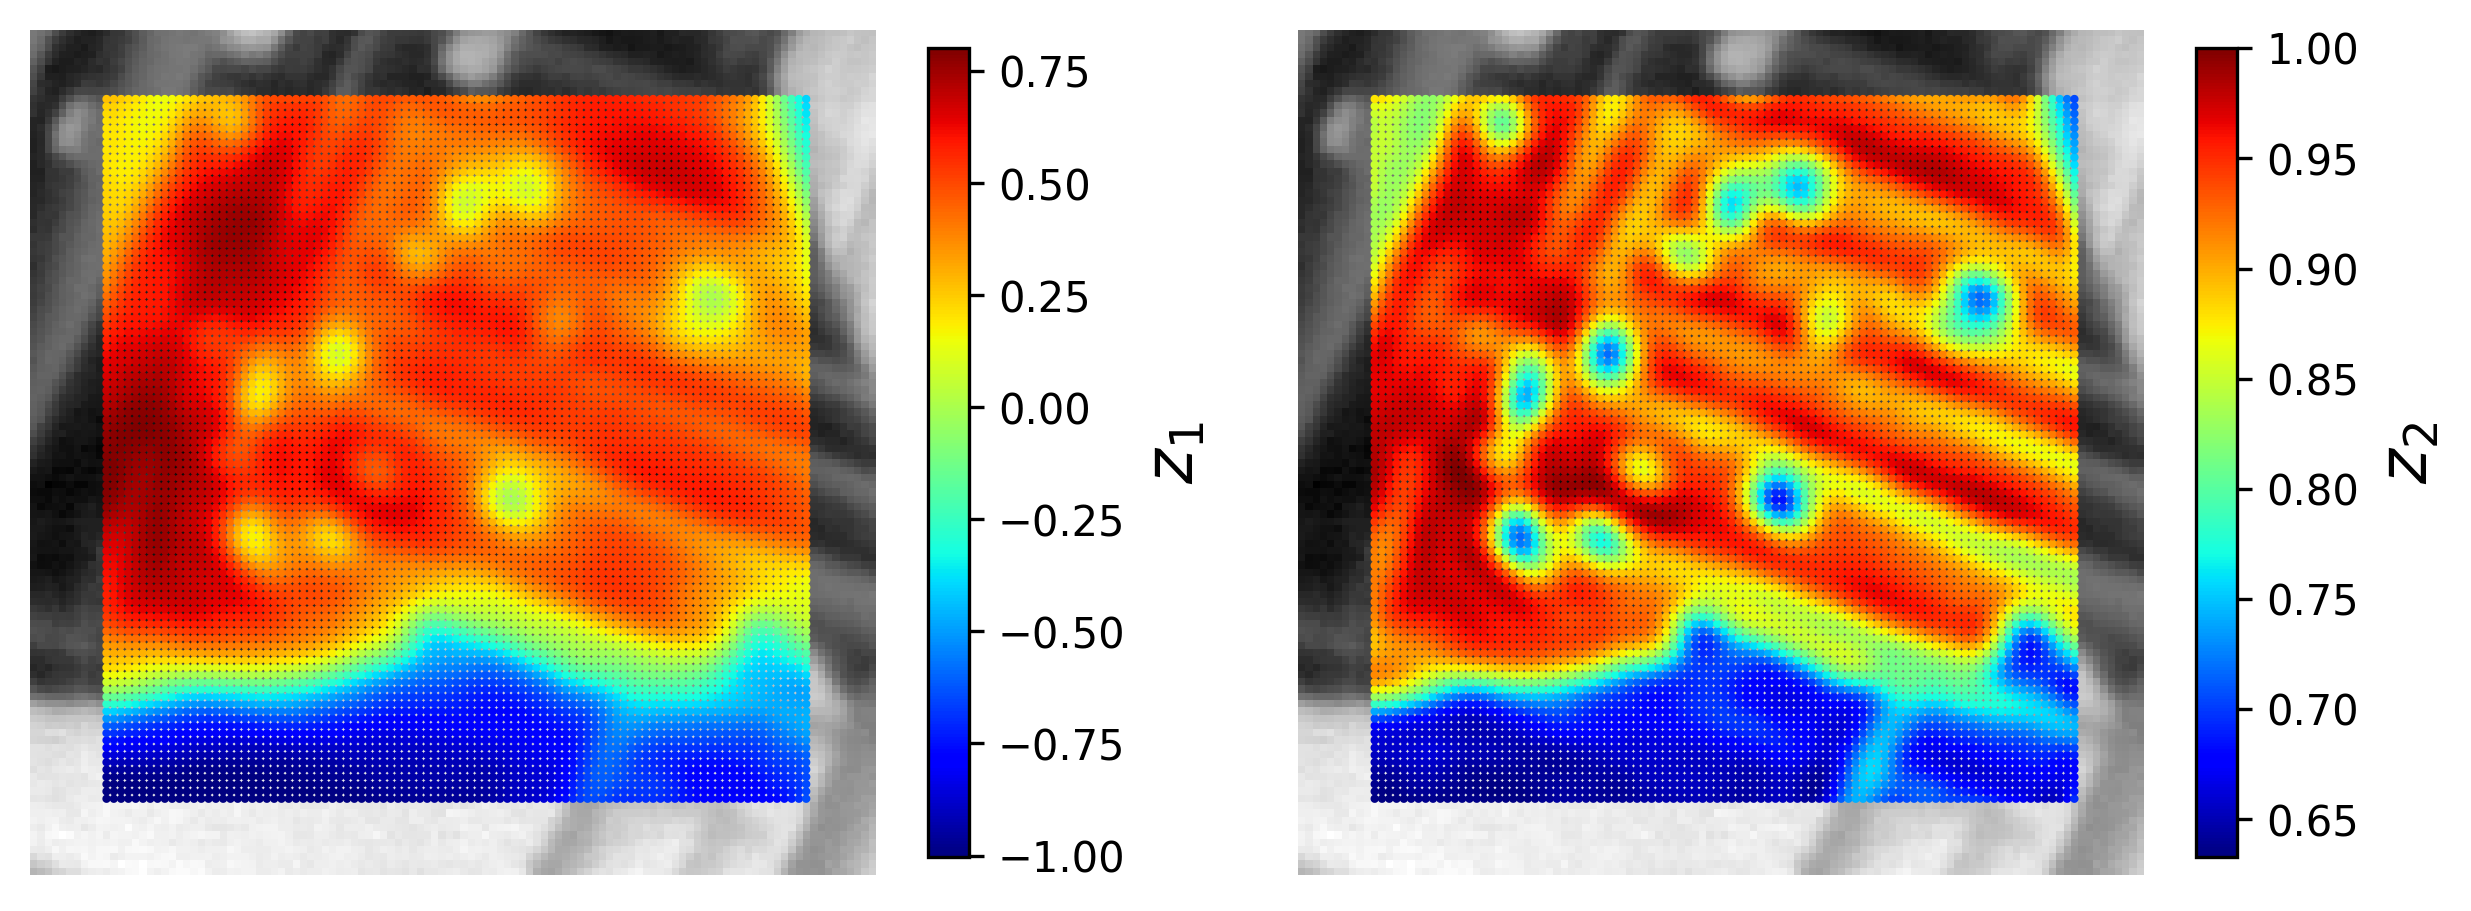

In [ ]:
embeded = dklgp.embed(X)
embeded = embeded / embeded.max()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi = 300)
ax1.imshow(patch_image, origin = "lower", cmap = 'gray')
im1=ax1.scatter(indices_all[:,1], indices_all[:,0], s=1, c = embeded[:,0].reshape(pix, pix), cmap = 'jet')
ax1.axis(False)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.7)
cbar1.set_label("$z_1$", fontsize=16)

ax2.imshow(patch_image, origin = "lower", cmap = 'gray')
im2=ax2.scatter(indices_all[:,1], indices_all[:,0], s=1, c = embeded[:,1].reshape(pix, pix), cmap = 'jet')
ax2.axis(False)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.7)
cbar2.set_label("$z_2$", fontsize=16)

# **4. Active experiment**

Now, let's see how DKL will work for in the (simulated) automated experiment. We can select a single acquisition function (EI, MU, UCB), or explore all three. Also here we choose scalarizer 1.

In [ ]:
## Some globals

exploration_steps = 100 #50
num_cycles        = 100 #20 or 200

xi = 0.01  # balances exploration and explitation for EI and qEI
cm = 'viridis'
shrink = 0.7

ts = 0.995  # (0.9995 for key 3) test data size: # Adjust ts to be as small as possible without running into error
rs = 42   #random state determines initial train data, 42 because answer to everything

In [ ]:
# determine acqusition funciton,
acq = 3  # 0 uses EI, 1 explores max uncertainty point, 2 uses UCB

rf = '/content/rf/'   #root folder
if not os.path.exists(rf):
    os.mkdir(rf)

acq_funcs = ['EI', 'MU', 'UCB']   #list corresponds to Func sel_next_point.
# root_folderEI = rf+"EI/"
# root_folderMU = rf+"MU/"
# root_folderUCB = rf+"UCB/"

if acq == 3:             # when acq = 3, run all acq_funcs
  if not os.path.exists(rf + acq_funcs[0]):
    os.mkdir(rf + acq_funcs[0])
  if not os.path.exists(rf + acq_funcs[1]):
    os.mkdir(rf + acq_funcs[1])
  if not os.path.exists(rf + acq_funcs[2]):
    os.mkdir(rf + acq_funcs[2])
elif acq < 3:
  if not os.path.exists(rf + acq_funcs[acq]):  # change root folder name when you change acquistion funciton
    os.mkdir(rf + acq_funcs[acq])

## DKL exploration



We can run exploration using a single acquisition function. Alternatively, we can explore all three and compare results.

In [ ]:
save_explore =  "/explore_dkl_record/"

y_targ = amp_all.reshape(-1)   #training output;
y_targ = (y_targ-y_targ.min())/(y_targ.max()-y_targ.min())
y = y_targ.reshape(-1)

# run DKL exploration with different acquisition functions
if acq < 3:   # if user select an individual acquistion function
  acq_idx = acq
  dkl_explore(save_explore, num_cycles)

elif acq == 3:  # if user selected to run all acquistion functions
  for i in range (3):
    acq_idx = i
    dkl_explore(save_explore, num_cycles)
  clear_output()


* Next, the exploration locations will be used for other analyses with different band energies

## DKL with counterfactual scalarizer

DKL exploration on band #2: (`0.65 - 0.75 eV`) and #3: `0.85 - 0.95 eV`

Note that our experimental trace saves the explored patch-spectrum pairs. Since scalarizer function operates on spectra, we can also calculate the counterfactual scalarizers - i.e. what would have been the exploration point if we have chosen a different criterion. This is useful when tuning the AE in real time.




In [ ]:
# Set band 2 as target property

y_targ = pha_all.reshape(-1)    #training output;
y_targ = (y_targ-y_targ.min())/(y_targ.max()-y_targ.min())
y = y_targ.reshape(-1)

save_counter1 = "/counter2/"

# run DKL counterfactual with different acquisition functions
if acq < 3:   # if user select an individual acquistion function
  acq_idx = acq
  dkl_counterfactual(y, save_counter1, num_cycles)

elif acq == 3:  # if user selected to run all acquistion functions
  for i in range (3):
    acq_idx = i
    dkl_counterfactual(y, save_counter1, num_cycles)
  clear_output()

DKL exploration on band #3: `0.85 - 0.95 eV`

Note that our experimental trace saves the explored patch-spectrum pairs. Since scalarizer function operates on spectra, we can also calculate the counterfactual scalarizers - i.e. what would have been the exploration point if we have chosen a different criterion. This is useful when tuning the AE in real time.

In [ ]:
y_targ = fre_all.reshape(-1)     #training output;
y_targ = (y_targ-y_targ.min())/(y_targ.max()-y_targ.min())
y = y_targ.reshape(-1)

save_counter2 = "/counter3/"

# run DKL counterfactual with different acquisition functions
if acq < 3:   # if user select an individual acquistion function
  acq_idx = acq
  dkl_counterfactual(y, save_counter2, num_cycles)

elif acq == 3:  # if user selected to run all acquistion functions
  for i in range (3):
    acq_idx = i
    dkl_counterfactual(y, save_counter2, num_cycles)
  clear_output()

## DKL on random grid

Step 3-1: Finally, let's run AE with the random spatial sampling

In [ ]:
#

y_targ = amp_all.reshape(-1)    #training output;
y_targ = (y_targ-y_targ.min())/(y_targ.max()-y_targ.min())
y = y_targ.reshape(-1)

save_random1 = "/random1/"

# run DKL random with different acquisition functions
if acq < 3:   # if user select an individual acquistion function
  acq_idx = acq
  dkl_random(y, save_random1, num_cycles)

elif acq == 3:  # if user selected to run all acquistion functions
  for i in range (3):
    acq_idx = i
    dkl_random(y, save_random1, num_cycles)
  clear_output()

In [ ]:
# #2 as target property
y_targ = pha_all.reshape(-1)  #training output;
y_targ = (y_targ-y_targ.min())/(y_targ.max()-y_targ.min())
y = y_targ.reshape(-1)

save_random2 = "/random2/"

# run DKL random with different acquisition functions
if acq < 3:   # if user select an individual acquistion function
  acq_idx = acq
  dkl_random(y, save_random2, num_cycles)

elif acq == 3:  # if user selected to run all acquistion functions
  for i in range (3):
    acq_idx = i
    dkl_random(y, save_random2, num_cycles)
  clear_output()

In [ ]:
#  #3 as target property
y_targ = fre_all.reshape(-1)    #training output;
y_targ = (y_targ-y_targ.min())/(y_targ.max()-y_targ.min())
y = y_targ.reshape(-1)

save_random3 = "/random3/"

# run DKL random with different acquisition functions
if acq < 3:   # if user select an individual acquistion function
  acq_idx = acq
  dkl_random(y, save_random3, num_cycles)

elif acq == 3:  # if user selected to run all acquistion functions
  for i in range (3):
    acq_idx = i
    dkl_random(y, save_random3, num_cycles)
  clear_output()

## Complete model

Now we can run the DKL on band 1 to create the complete model.

In [ ]:
# 1

y_targ = amp_all.reshape(-1)   #training output;
y_targ = (y_targ-y_targ.min())/(y_targ.max()-y_targ.min())
y = y_targ.reshape(-1)

save_mature_full = "/mature_full_record/"

# run real-time DKL, mature DKL, and full DKL with different acquisition functions
if acq < 3:   # if user select an individual acquistion function
  acq_idx = acq
  dkl_mature_full(y, save_mature_full, num_cycles)

elif acq == 3:  # if user selected to run all acquistion functions
  for i in range (3):
    acq_idx = i
    dkl_mature_full(y, save_mature_full, num_cycles)
  clear_output()

## Zip and download all results


In [ ]:
!zip -r /content/Forensic_Toy_Data.zip /content/rf   # zip the root folder

# Use this code if you would like to download the analysis to your computer
# from google.colab import files
# files.download("/content/Forensic_EELS_NP1_20explore.zip")

  adding: content/rf/ (stored 0%)
  adding: content/rf/EI/ (stored 0%)
  adding: content/rf/EI/explore_dkl_record/ (stored 0%)
  adding: content/rf/EI/explore_dkl_record/record35.npz (deflated 14%)
  adding: content/rf/EI/explore_dkl_record/record43.npz (deflated 14%)
  adding: content/rf/EI/explore_dkl_record/record90.npz (deflated 15%)
  adding: content/rf/EI/explore_dkl_record/record73.npz (deflated 14%)
  adding: content/rf/EI/explore_dkl_record/record46.npz (deflated 16%)
  adding: content/rf/EI/explore_dkl_record/record28.npz (deflated 19%)
  adding: content/rf/EI/explore_dkl_record/record47.npz (deflated 18%)
  adding: content/rf/EI/explore_dkl_record/record57.npz (deflated 17%)
  adding: content/rf/EI/explore_dkl_record/record60.npz (deflated 16%)
  adding: content/rf/EI/explore_dkl_record/record61.npz (deflated 17%)
  adding: content/rf/EI/explore_dkl_record/record66.npz (deflated 18%)
  adding: content/rf/EI/explore_dkl_record/record18.npz (deflated 15%)
  adding: content/rf/



# **5. Forensic analysis**

In [ ]:
#Use this code if you get locale error when !wget the previous analysis data

'''
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
'''

'\nimport locale\ndef getpreferredencoding(do_setlocale = True):\n    return "UTF-8"\nlocale.getpreferredencoding = getpreferredencoding\n'

In [ ]:
# If you would like to explore a stored data set
use_own_data = 'N'

%cd "/content/"
if use_own_data == "Y":
    !wget https://www.dropbox.com/s/2kqznxkui0ajdr2/Forensic_EELS_NP1_20explore.zip
    !unzip Forensic_EELS_NP1_20explore.zip

/content


Import PyroVED for the VAE analysis

In [ ]:
%%capture
!pip install --upgrade git+https://github.com/ziatdinovmax/pyroved.git

In [ ]:
import os
import glob
import h5py
from copy import deepcopy as dc

from scipy import ndimage
from sklearn import decomposition

import pyroved as pv

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cv2

import atomai as aoi
from atomai.utils import extract_patches_
from atomai import utils

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

## Learning curve analysis

Load results of  **Live model** (the actual model that is being trained during the experiment), **Final model** (the model available in the end of experiment), and **Complete model** (trained on full data if it is available, i.e. via grid measurement)

In [ ]:
if use_own_data == 'Y':

    exploration_steps = len(glob.glob("content/rf/EI/random_band1/record*")) # This should be 20
    rf = "/content/rf/"
    print(exploration_steps)

NameError: ignored

In [ ]:
# Create array to save results of live and complete DKL models
# save results from EI acuqisition funciton

var_compare = np.empty((3, 3, exploration_steps))  # uncertainty
var_dev_compare = np.empty((3, 3, exploration_steps)) # uncertainty variation
nextpoint_uncertainty_compare = np.empty((3, 3, exploration_steps)) # predicted next point uncertainty
nextpoint_measure_compare = np.empty((3, 3, exploration_steps)) # next point ground truth
nextpoint_pred_compare = np.empty((3, 3, exploration_steps)) # next point prediction

for acq_idx in range(3):
  os.chdir (rf + acq_funcs[acq_idx] + '/mature_full_record')

  for i in range (exploration_steps):
    # load results of DKL
    rec = np.load("record{}.npz".format(i))
    var_compare[acq_idx, :, i] = rec['var'].mean(), rec['var0'].mean(), rec['var1'].mean()
    var_dev_compare[acq_idx, :, i] = np.std(rec['var']), np.std(rec['var0']), np.std(rec['var1'])

    nextpoint_uncertainty_compare[acq_idx, :, i] = rec['var'].max(), rec['var0'].max(), rec['var1'].max()
    nextpoint_measure_compare[acq_idx, :, i] = rec['y_test'][rec['var'].argmax()], rec['y_test'][rec['var0'].argmax()], rec['y_test'][rec['var1'].argmax()]
    nextpoint_pred_compare[acq_idx, :, i] = rec['mean'][rec['var'].argmax()], rec['mean0'][rec['var0'].argmax()], rec['mean1'][rec['var1'].argmax()]

Plot preditive uncertainty (of each model) as a function of automated experiment step. Shown is the average uncertainty for all patches, and the distribution of uncertainties.

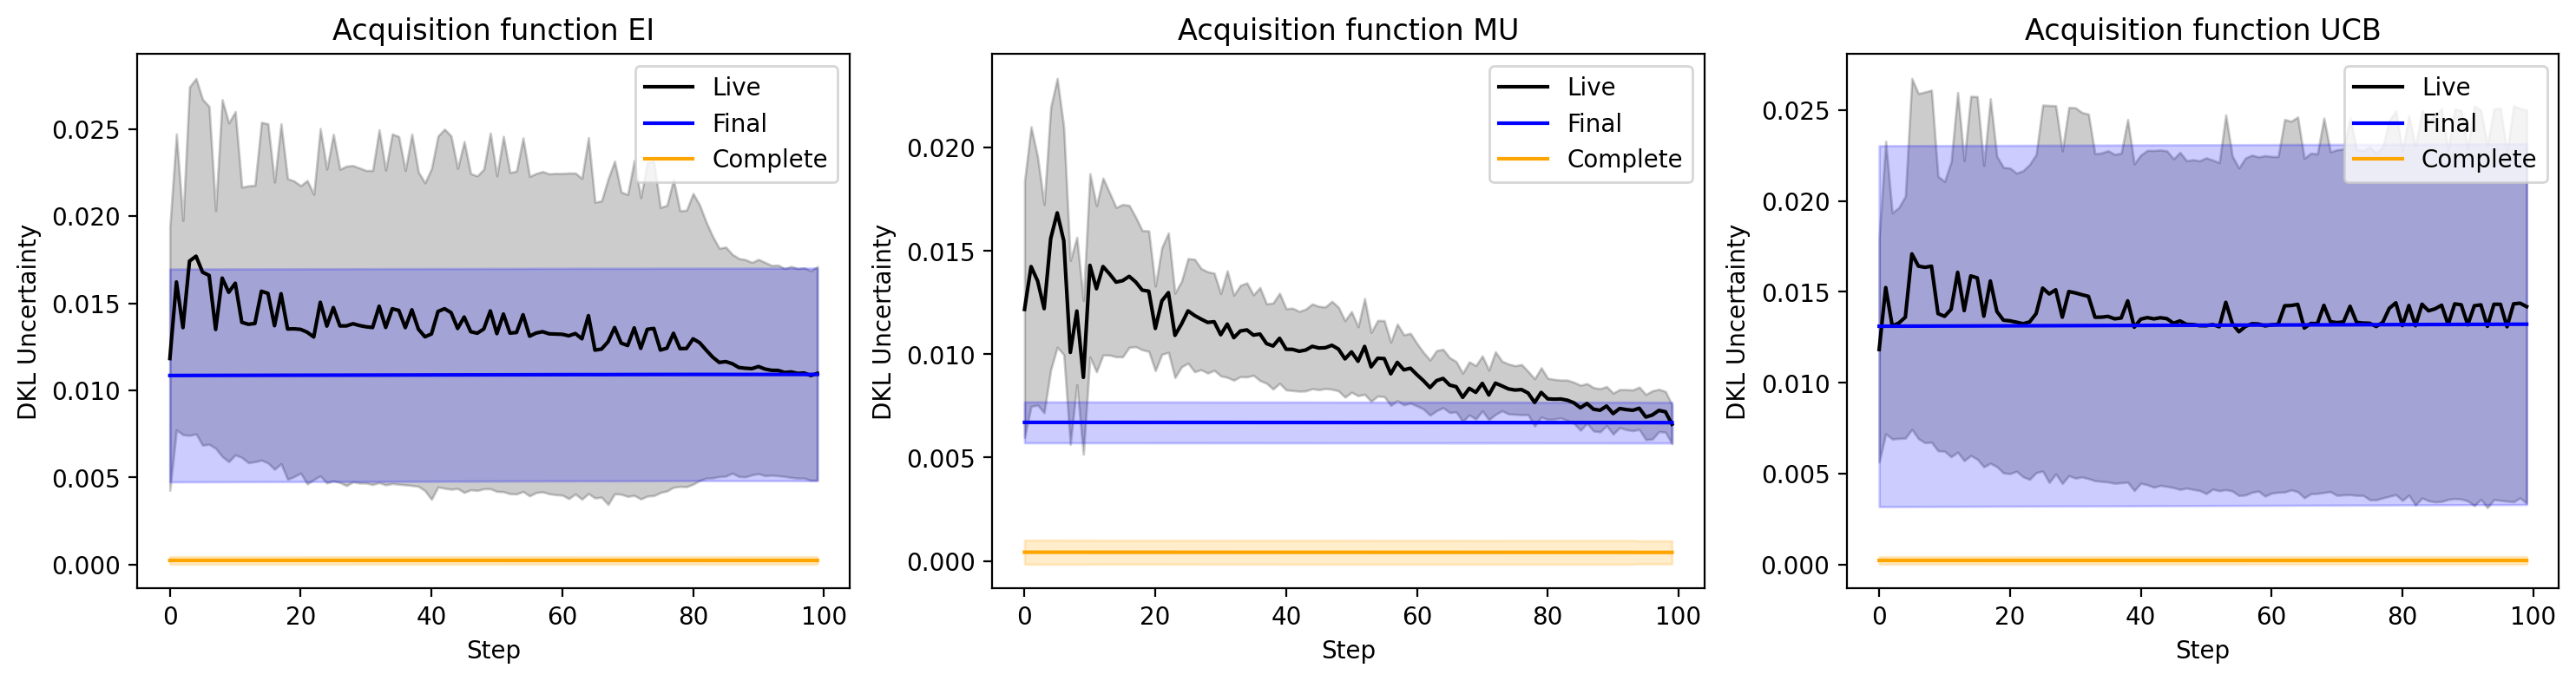

In [ ]:
s = np.arange(exploration_steps) #step

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18, 4), dpi = 200)

#Plot EI
ax1.set_title("Acquisition function EI")
ax1.plot(s, var_compare[0, 0,], c= 'black', label = "Live")
ax1.fill_between(s, var_compare[0, 0,]-var_dev_compare[0, 0,],
                 var_compare[0, 0,]+var_dev_compare[0, 0,], color='black', alpha=0.2)
ax1.plot(s, var_compare[0, 1,], c = 'blue', label = "Final")
ax1.fill_between(s, var_compare[0, 1,]-var_dev_compare[0, 1,],
                 var_compare[0, 1,]+var_dev_compare[0, 1,],  color='blue', alpha=0.2)
ax1.plot(s, var_compare[0, 2,], c = 'orange', label = "Complete")
ax1.fill_between(s, var_compare[0, 2,]-var_dev_compare[0, 2,],
                 var_compare[0, 2,]+var_dev_compare[0, 2,], color='orange', alpha=0.2)
ax1.set_ylabel("DKL Uncertainty")
ax1.set_xlabel('Step')
ax1.legend()

#Plot MU
ax2.set_title("Acquisition function MU")
ax2.plot(s, var_compare[1, 0,], c= 'black', label = "Live")
ax2.fill_between(s, var_compare[1, 0,]-var_dev_compare[1, 0,],
                 var_compare[1, 0,]+var_dev_compare[1, 0,], color='black', alpha=0.2)
ax2.plot(s, var_compare[1, 1,], c = 'blue', label = "Final")
ax2.fill_between(s, var_compare[1, 1,]-var_dev_compare[1, 1,],
                 var_compare[1, 1,]+var_dev_compare[1, 1,],  color='blue', alpha=0.2)
ax2.plot(s, var_compare[1, 2,], c = 'orange', label = "Complete")
ax2.fill_between(s, var_compare[1, 2,]-var_dev_compare[1, 2,],
                 var_compare[1, 2,]+var_dev_compare[1, 2,], color='orange', alpha=0.2)
ax2.set_ylabel("DKL Uncertainty")
ax2.set_xlabel('Step')
ax2.legend()

#Plot UCB
ax3.set_title("Acquisition function UCB")
ax3.plot(s, var_compare[2, 0,], c= 'black', label = "Live")
ax3.fill_between(s, var_compare[2, 0,]-var_dev_compare[2, 0,],
                 var_compare[2, 0,]+var_dev_compare[2, 0,], color='black', alpha=0.2)
ax3.plot(s, var_compare[2, 1,], c = 'blue', label = "Final")
ax3.fill_between(s, var_compare[2, 1,]-var_dev_compare[2, 1,],
                 var_compare[2, 1,]+var_dev_compare[2, 1,],  color='blue', alpha=0.2)
ax3.plot(s, var_compare[2, 2,], c = 'orange', label = "Complete")
ax3.fill_between(s, var_compare[2, 2,]-var_dev_compare[2, 2,],
                 var_compare[2, 2,]+var_dev_compare[2, 2,], color='orange', alpha=0.2)
ax3.set_ylabel("DKL Uncertainty")
ax3.set_xlabel('Step')
ax3.legend()

plt.show()

Now, let's plot the maximum uncertainty for each model as a function of step. In principle, we can also calculate the acquisition functions.

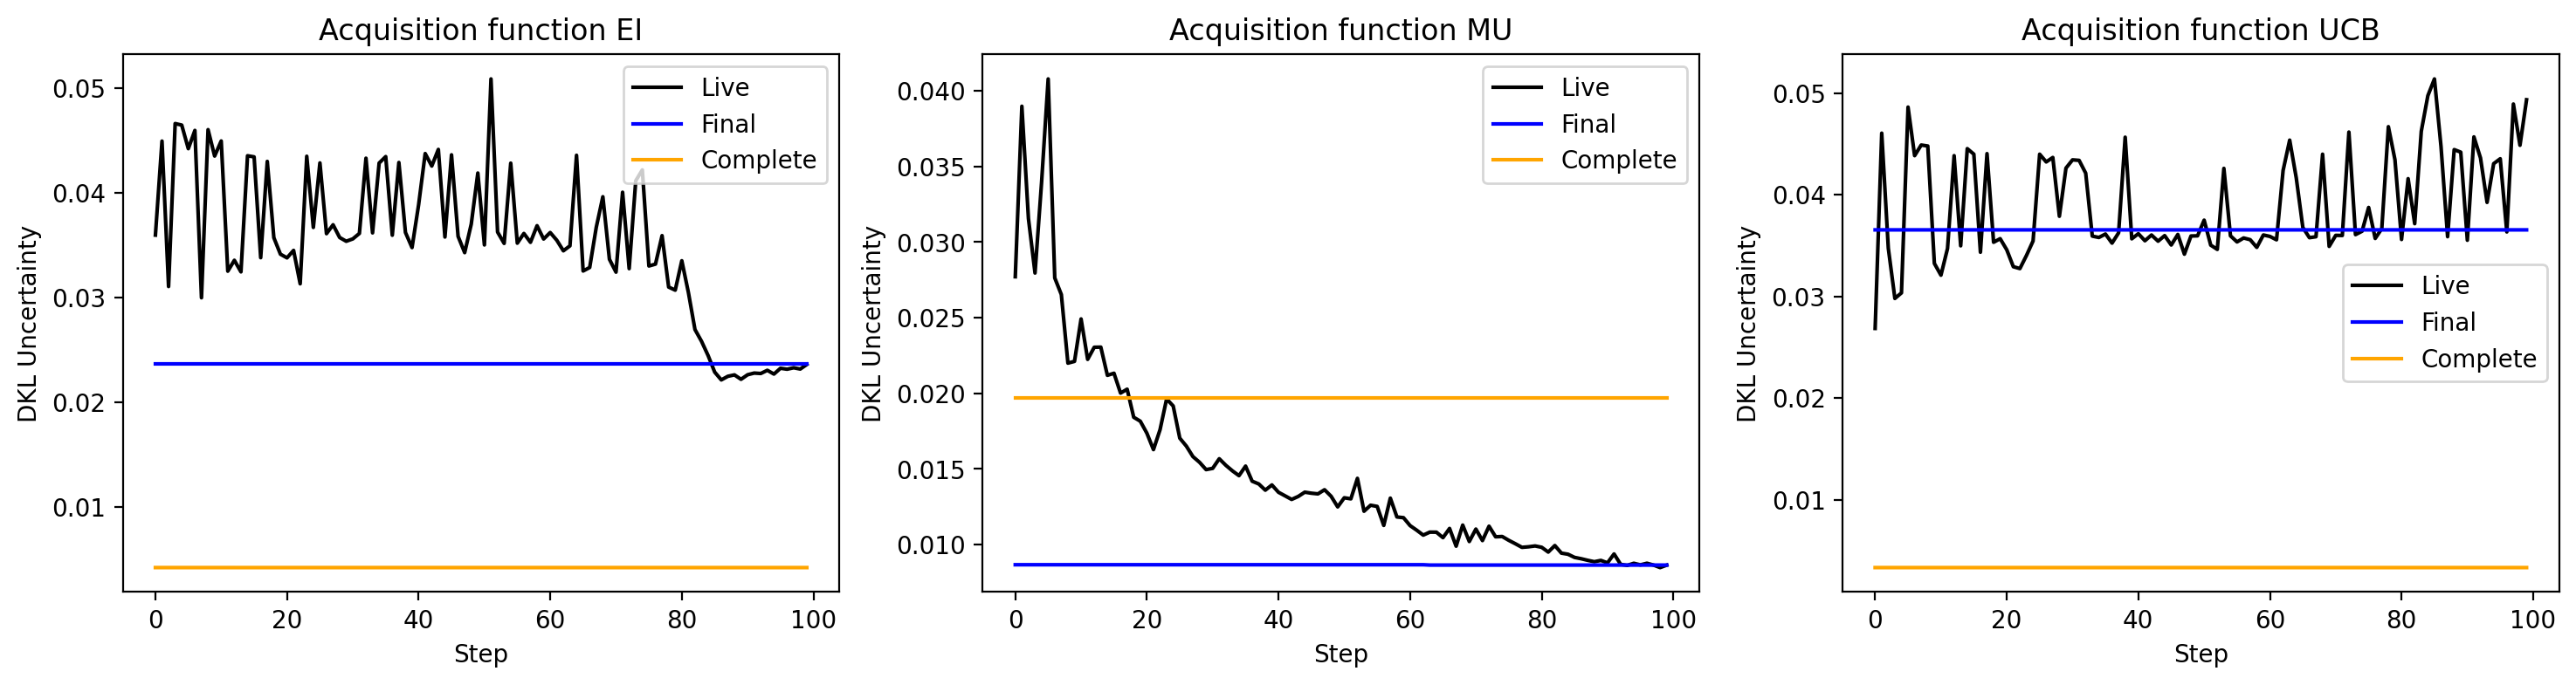

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 4), dpi = 200)

# Plot EI
ax1.set_title("Acquisition function EI")
ax1.plot(s, nextpoint_uncertainty_compare[0, 0,], c= 'black', label = "Live")
ax1.plot(s, nextpoint_uncertainty_compare[0, 1,], c = 'blue', label = "Final")
ax1.plot(s, nextpoint_uncertainty_compare[0, 2,], c = 'orange', label = "Complete")
ax1.set_ylabel("DKL Uncertainty"); ax1.set_xlabel('Step'); ax1.legend()

# Plot MU
ax2.set_title("Acquisition function MU")
ax2.plot(s, nextpoint_uncertainty_compare[1, 0,], c= 'black', label = "Live")
ax2.plot(s, nextpoint_uncertainty_compare[1, 1,], c = 'blue', label = "Final")
ax2.plot(s, nextpoint_uncertainty_compare[1, 2,], c = 'orange', label = "Complete")
ax2.set_ylabel("DKL Uncertainty"); ax2.set_xlabel('Step'); ax2.legend()

# Plot UCB
ax3.set_title("Acquisition function UCB")
ax3.plot(s, nextpoint_uncertainty_compare[2, 0,], c= 'black', label = "Live")
ax3.plot(s, nextpoint_uncertainty_compare[2, 1,], c = 'blue', label = "Final")
ax3.plot(s, nextpoint_uncertainty_compare[2, 2,], c = 'orange', label = "Complete")
ax3.set_ylabel("DKL Uncertainty"); ax3.set_xlabel('Step'); ax3.legend()

plt.show()

Next measurement value from each model as a function of step. For now, the next point is simply defined as maximum uncertainty (we can also use EI or UCB function; or next point from experiment)

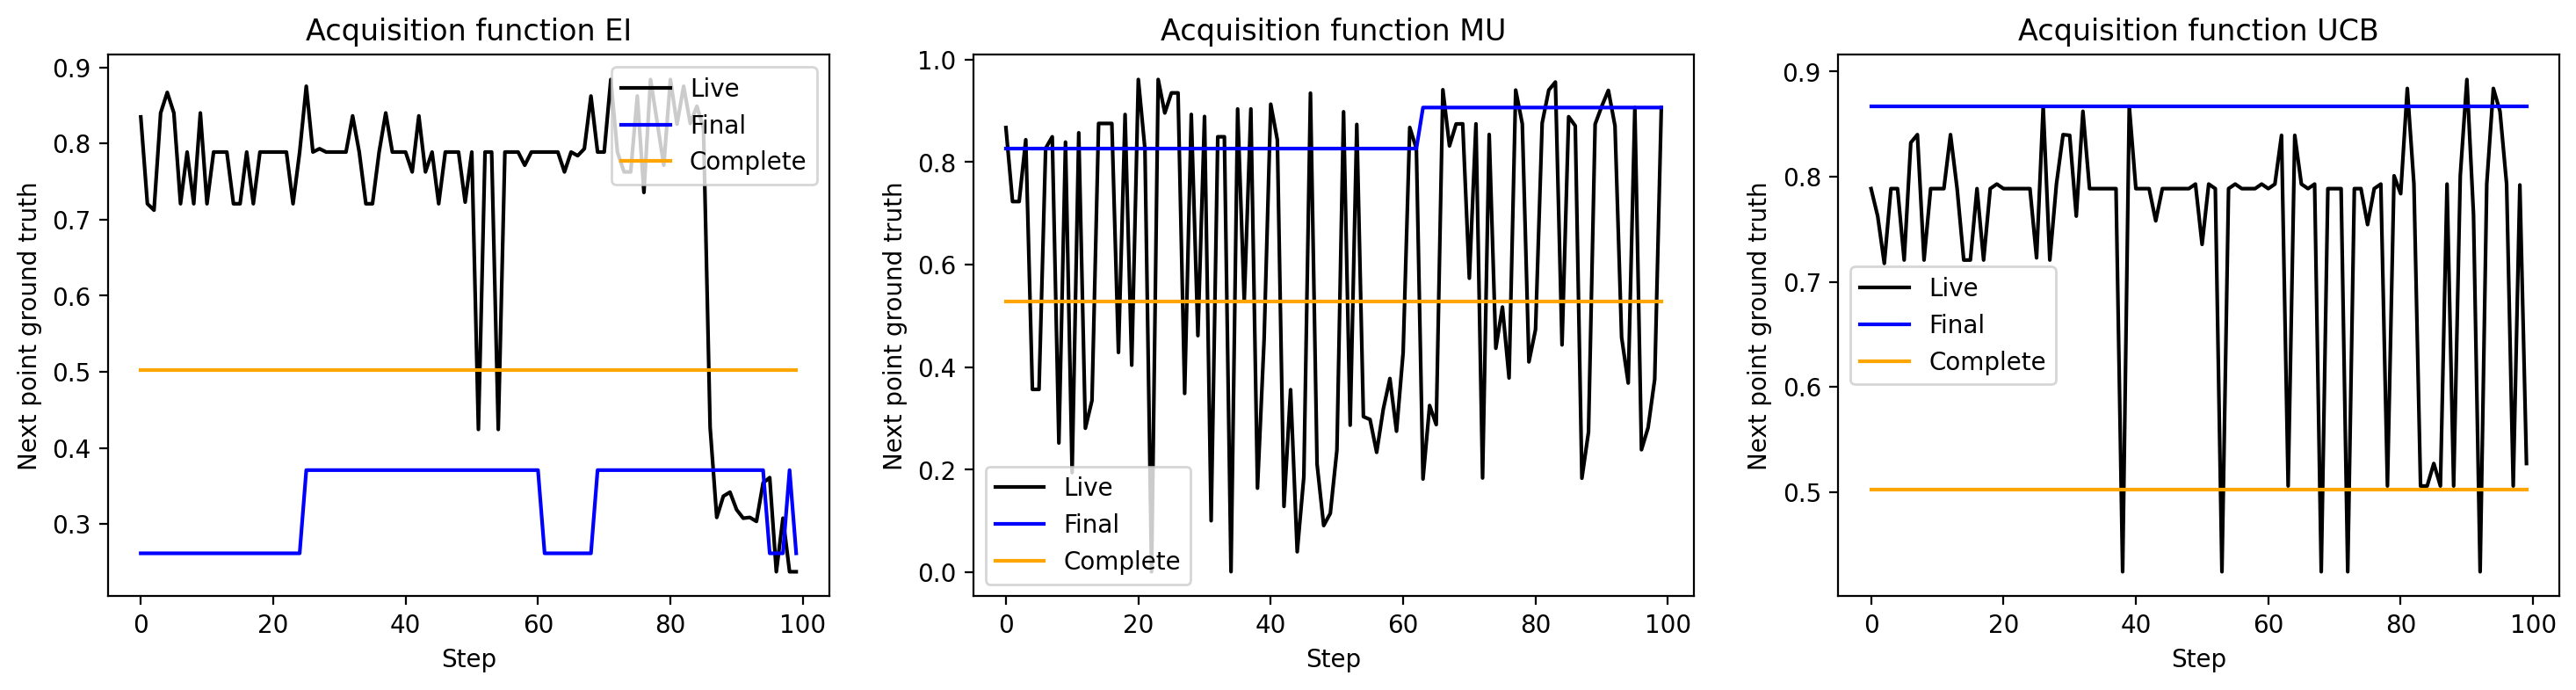

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 4), dpi = 200)

# Plot EI
ax1.set_title("Acquisition function EI")
ax1.plot(s, nextpoint_measure_compare[0, 0,], c= 'black', label = "Live")
ax1.plot(s, nextpoint_measure_compare[0, 1,], c = 'blue', label = "Final")
ax1.plot(s, nextpoint_measure_compare[0, 2,], c = 'orange', label = "Complete")
ax1.set_ylabel("Next point ground truth"); ax1.set_xlabel('Step'); ax1.legend()

# Plot MU
ax2.set_title("Acquisition function MU")
ax2.plot(s, nextpoint_measure_compare[1, 0,], c= 'black', label = "Live")
ax2.plot(s, nextpoint_measure_compare[1, 1,], c = 'blue', label = "Final")
ax2.plot(s, nextpoint_measure_compare[1, 2,], c = 'orange', label = "Complete")
ax2.set_ylabel("Next point ground truth"); ax2.set_xlabel('Step'); ax2.legend()

# Plot UCB
ax3.set_title("Acquisition function UCB")
ax3.plot(s, nextpoint_measure_compare[2, 0,], c= 'black', label = "Live")
ax3.plot(s, nextpoint_measure_compare[2, 1,], c = 'blue', label = "Final")
ax3.plot(s, nextpoint_measure_compare[2, 2,], c = 'orange', label = "Complete")
ax3.set_ylabel("Next point ground truth"); ax3.set_xlabel('Step'); ax3.legend()

plt.show()

Next point prediction from each model as a function of step. For now, the next point is simply defined as maximum uncertainty (we can use EI or UCB function, or next point from experiment)

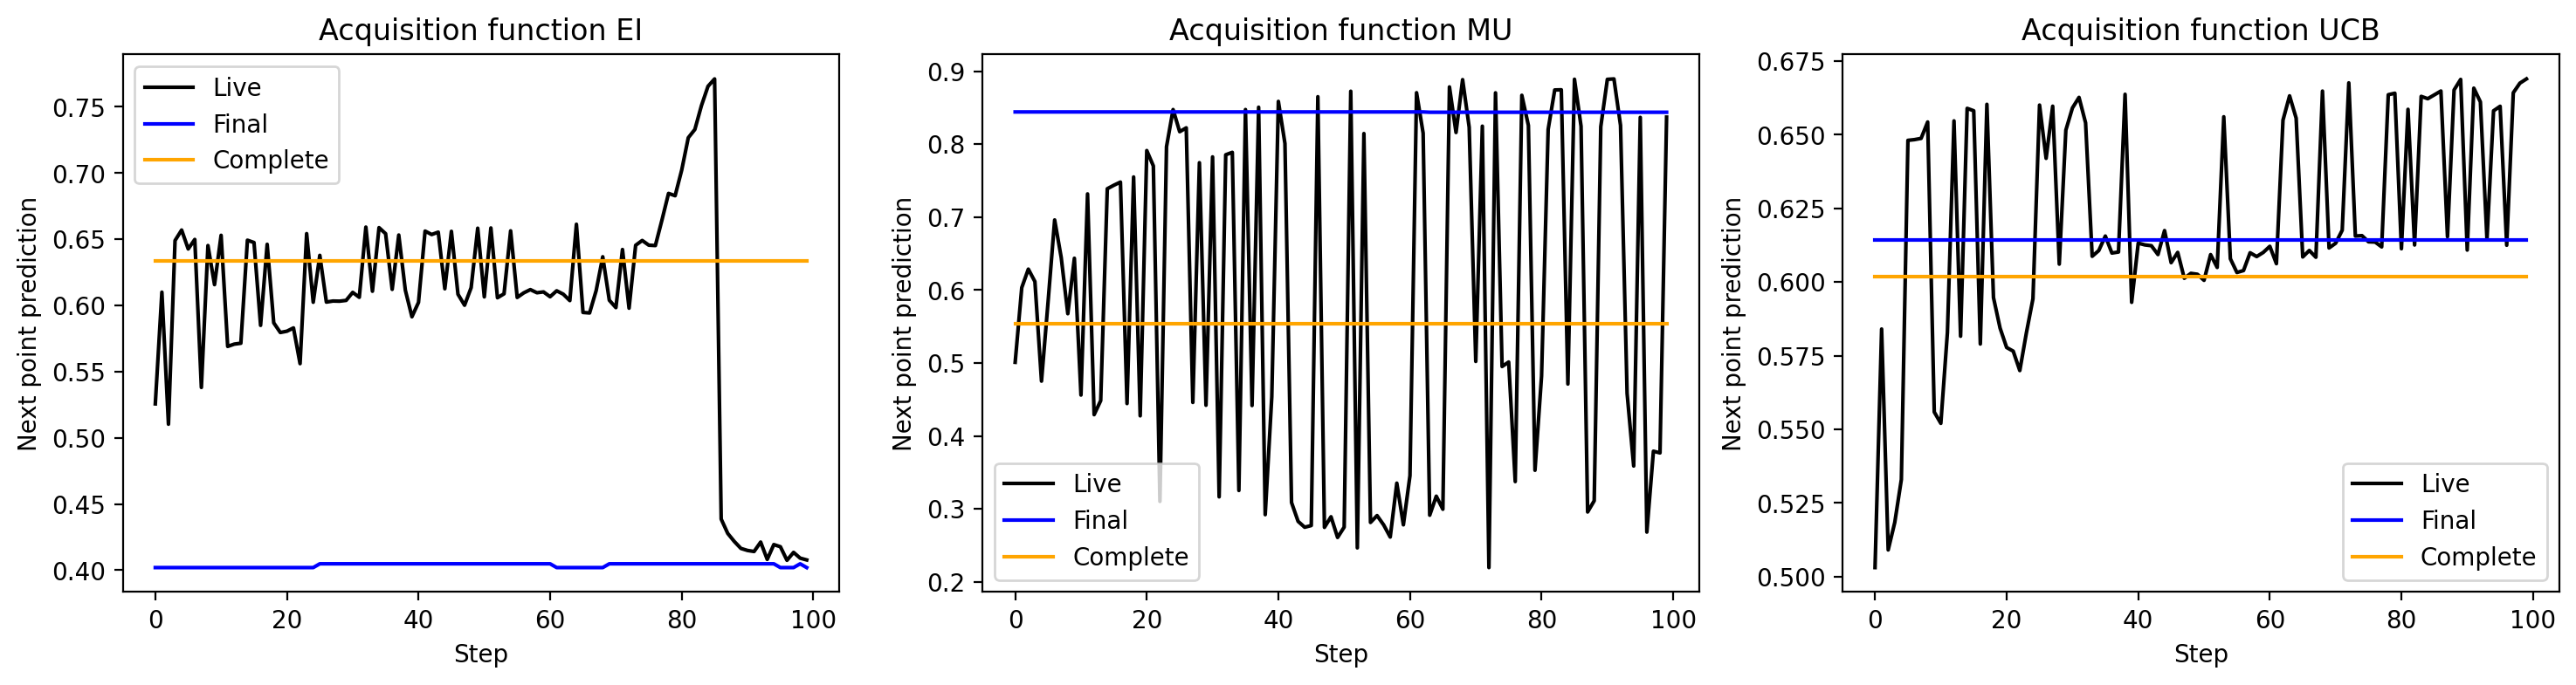

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 4), dpi = 200)

# Plot EI
ax1.set_title("Acquisition function EI")
ax1.plot(s, nextpoint_pred_compare[0, 0,], c= 'black', label = "Live")
ax1.plot(s, nextpoint_pred_compare[0, 1,], c = 'blue', label = "Final")
ax1.plot(s, nextpoint_pred_compare[0, 2,], c = 'orange', label = "Complete")
ax1.set_ylabel("Next point prediction"); ax1.set_xlabel('Step'); ax1.legend()

# Plot MU
ax2.set_title("Acquisition function MU")
ax2.plot(s, nextpoint_pred_compare[1, 0,], c= 'black', label = "Live")
ax2.plot(s, nextpoint_pred_compare[1, 1,], c = 'blue', label = "Final")
ax2.plot(s, nextpoint_pred_compare[1, 2,], c = 'orange', label = "Complete")
ax2.set_ylabel("Next point prediction"); ax2.set_xlabel('Step'); ax2.legend()

# Plot UCB
ax3.set_title("Acquisition function UCB")
ax3.plot(s, nextpoint_pred_compare[2, 0,], c= 'black', label = "Live")
ax3.plot(s, nextpoint_pred_compare[2, 1,], c = 'blue', label = "Final")
ax3.plot(s, nextpoint_pred_compare[2, 2,], c = 'orange', label = "Complete")
ax3.set_ylabel("Next point prediction"); ax3.set_xlabel('Step'); ax3.legend()

plt.show()

## Regret analysis

We define regret as the difference between live DKL prediction (mean) and final DKL prediction (mean).



In [ ]:
# Create array to save results of real time and matured DKL models
# save results from three acuqisition funciton
reg = np.empty((3, 2, exploration_steps))  # save the difference of predictions between real time DKL and trained DKL at each step; as well as deviation

for acq_idx in range (3):
  os.chdir (rf + acq_funcs[acq_idx] + save_mature_full)
  for i in range (exploration_steps):
    # load results
    rec = np.load("record{}.npz".format(i))
    mean_d = rec['mean']-rec['mean0']
    reg[acq_idx,:,i] = mean_d.mean(), np.std(mean_d)


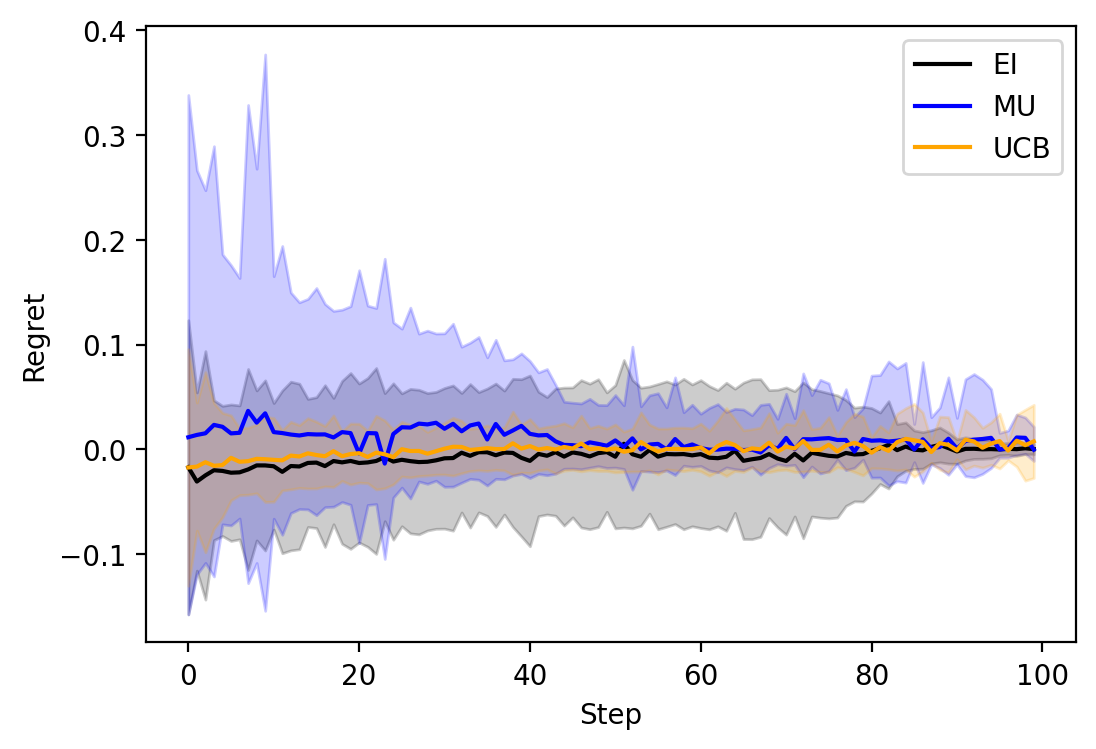

In [ ]:
fig, ax = plt.subplots(figsize = (6, 4), dpi = 200)

ax.plot(s, reg[0,0,], c= 'black', label = "EI")
ax.fill_between(s, reg[0,0,]-reg[0,1,], reg[0,0,]+reg[0,1,],
                color='black', alpha=0.2)

ax.plot(s, reg[1,0,], c= 'blue', label = "MU")
ax.fill_between(s, reg[1,0,]-reg[1,1,], reg[1,1,]+reg[1,1,],
                color='blue', alpha=0.2)

ax.plot(s, reg[2,0,], c= 'orange', label = "UCB")
ax.fill_between(s, reg[2,0,]-reg[2,1,], reg[2,0,]+reg[2,1,],
                color='orange', alpha=0.2)

ax.set_ylabel("Regret")
ax.set_xlabel('Step')
plt.legend()
plt.show()

## Real space trajectory analysis

Now, let's explore the real space trajectories for the experiment with different acquisition functions. This allows us to compare how different acquisition functions explore the image plane, and in which sequence they pick different structural objects.

In [ ]:
traj_EI = np.zeros((exploration_steps, 2))
traj_MU = np.zeros((exploration_steps, 2))
traj_UCB = np.zeros((exploration_steps, 2))

for i in range (exploration_steps):
  os.chdir (rf + acq_funcs[0] + save_explore)
  rec = np.load("record{}.npz".format(i))
  nextpoint = rec ['next_point']
  traj_EI [i, ] = nextpoint

  try:
    os.chdir (rf + acq_funcs[1] + save_explore)
    rec = np.load("record{}.npz".format(i))
    nextpoint = rec ['next_point']
    traj_MU [i, ] = nextpoint
  except FileNotFoundError:
    pass

  os.chdir (rf + acq_funcs[2] + save_explore)
  rec = np.load("record{}.npz".format(i))
  nextpoint = rec ['next_point']
  traj_UCB [i, ] = nextpoint

(-0.5, 115.5, -0.5, 115.5)

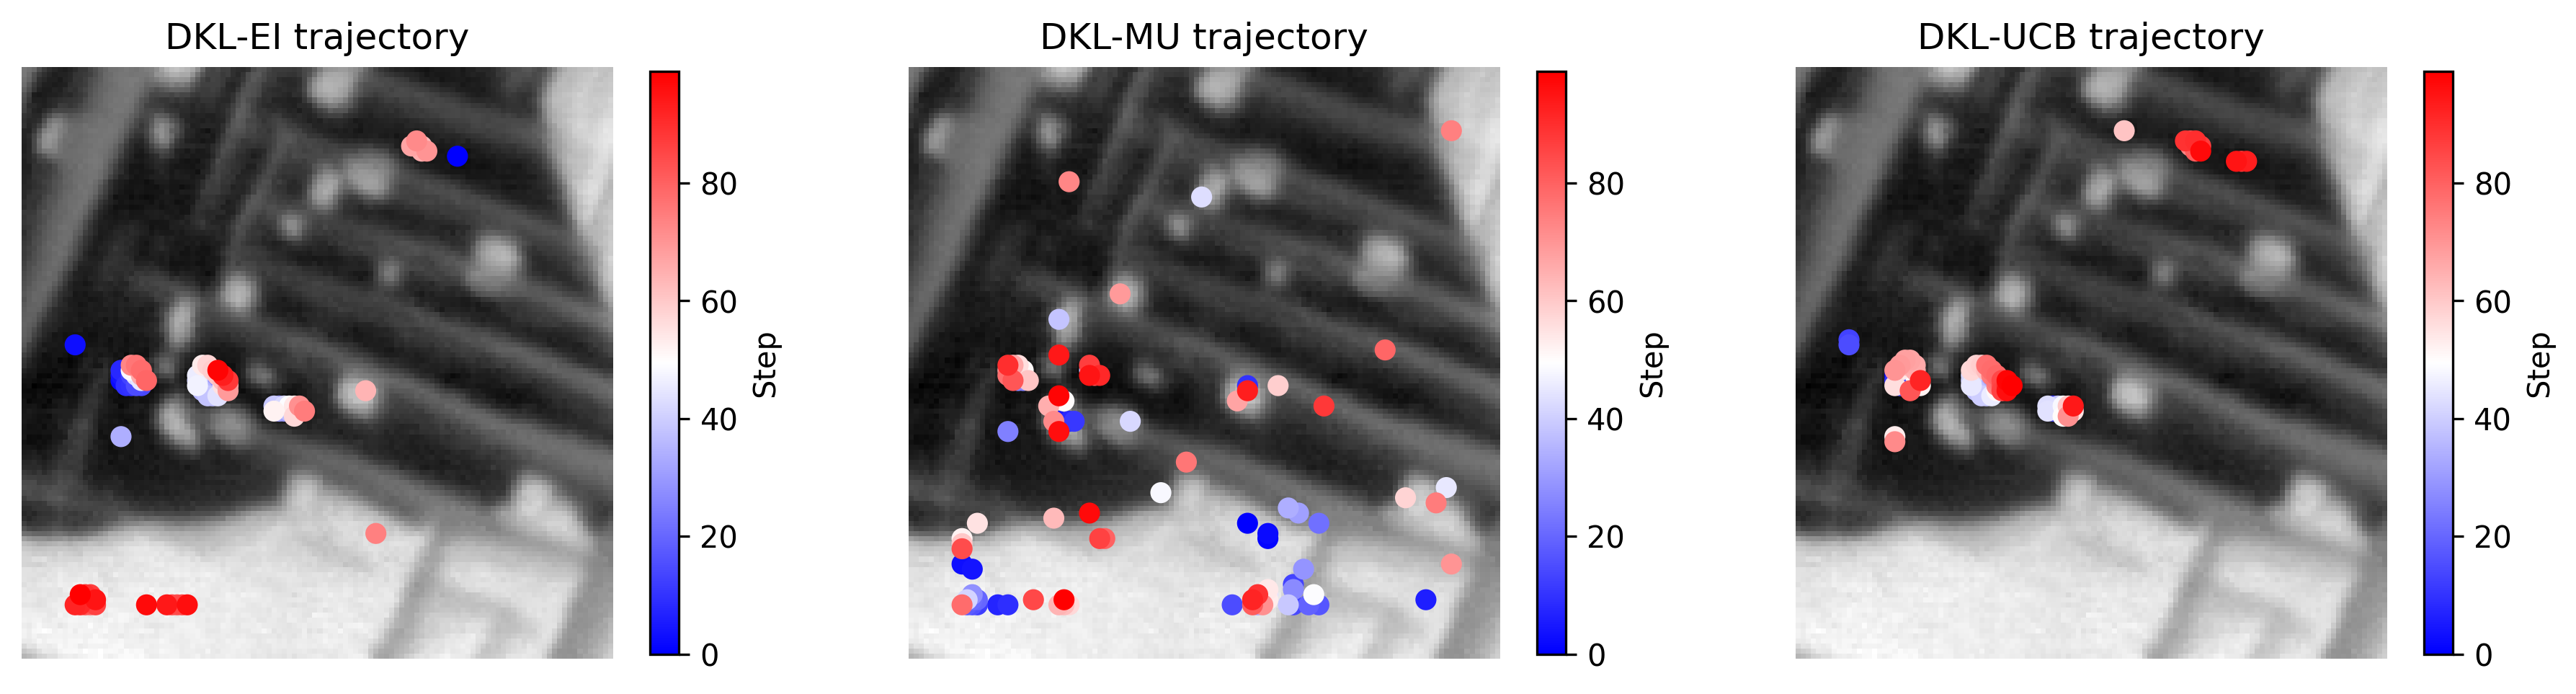

In [ ]:
full_img = pola
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi = 300)

cm = 'gray'
shrink = 0.7

ax1.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im1 = ax1.scatter(traj_EI[:,1], traj_EI[:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im1, ax=ax1, shrink = shrink, label = "Step")
ax1.set_title("DKL-EI trajectory")
ax1.axis('off')

ax2.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im2 = ax2.scatter(traj_MU[:,1], traj_MU[:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im2, ax=ax2, shrink = shrink, label = "Step")
ax2.set_title("DKL-MU trajectory")
ax2.axis('off')

ax3.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im3 = ax3.scatter(traj_UCB[:,1], traj_UCB[:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im3, ax=ax3, shrink = shrink, label = "Step")
ax3.set_title("DKL-UCB trajectory")
ax3.axis('off')

## Feature discovery

Here, we explore what are the characteristic structural elements of the points explored during the AE. To do it, we use the VAE (or invariant VAE) analysis of the image patches in the **experimental trace**.

First, we run it for the EI acquisition function

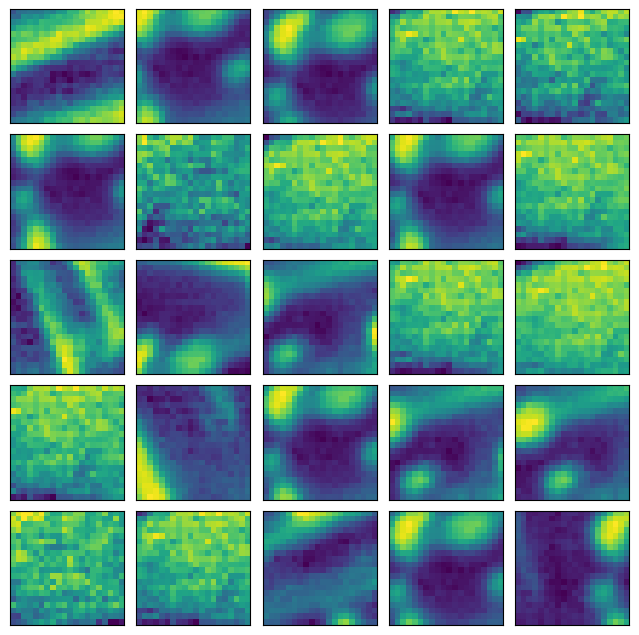

In [ ]:
# Load DKL sampled data
os.chdir(rf + acq_funcs[0] + save_explore)
rec = np.load("final_traindata.npz")
X_train = rec['X_train']

# Initialize VAE train loader
vae_EI_data = torch.tensor(X_train.reshape(-1, ws, ws)).float()
vae_EI_loader = pv.utils.init_dataloader(vae_EI_data, batch_size=32, device = 'cuda')

np.random.seed(1)
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for ax in axes.flat:
    i = np.random.randint(len(vae_EI_data))
    ax.imshow(vae_EI_data[i].cpu(), interpolation='nearest')

In [ ]:
tensor = vae_EI_data

# Print tensor properties
print("Tensor properties:")
print("Data type:", tensor.dtype)
print("Device:", tensor.device)
print("Shape:", tensor.shape)
print("Number of dimensions:", tensor.dim())
print("Total number of elements:", tensor.numel())

Tensor properties:
Data type: torch.float32
Device: cuda:0
Shape: torch.Size([147, 20, 20])
Number of dimensions: 3
Total number of elements: 58800


In [ ]:
# train VAE using the constructed stack of subimages
in_dim = (ws, ws)
rvae_EI = pv.models.iVAE(in_dim, latent_dim=2, invariances='r',
                      sampler_d='gaussian', decoder_sig=0.01, seed=42)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae_EI)

# Train for n epochs:
for e in range(200):
    trainer.step(vae_EI_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: 186214.1446
Epoch: 2 Training loss: 115125.4857
Epoch: 3 Training loss: 70323.8748
Epoch: 4 Training loss: 59182.3125
Epoch: 5 Training loss: 51780.6241
Epoch: 6 Training loss: 41040.6280
Epoch: 7 Training loss: 38474.2588
Epoch: 8 Training loss: 37179.4579
Epoch: 9 Training loss: 35590.8206
Epoch: 10 Training loss: 33233.5195
Epoch: 11 Training loss: 32540.8457
Epoch: 12 Training loss: 30625.4901
Epoch: 13 Training loss: 31512.2824
Epoch: 14 Training loss: 28849.6482
Epoch: 15 Training loss: 28477.6990
Epoch: 16 Training loss: 27305.7343
Epoch: 17 Training loss: 26605.4415
Epoch: 18 Training loss: 26572.8102
Epoch: 19 Training loss: 26300.4721
Epoch: 20 Training loss: 26352.4973
Epoch: 21 Training loss: 25977.2648
Epoch: 22 Training loss: 26423.8170
Epoch: 23 Training loss: 27036.4516
Epoch: 24 Training loss: 27261.9429
Epoch: 25 Training loss: 27994.5173
Epoch: 26 Training loss: 29786.5476
Epoch: 27 Training loss: 28111.7923
Epoch: 28 Training loss: 28496.5981

Text(0, 0.5, '$z_1$')

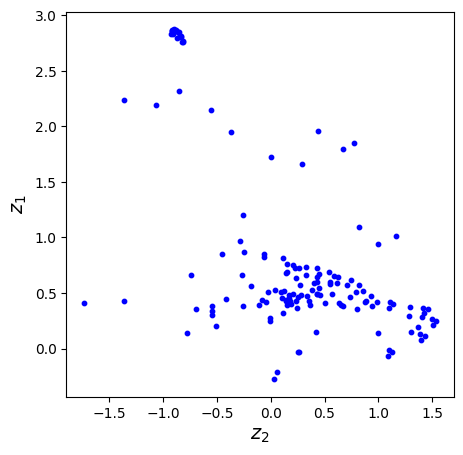

In [ ]:
z_mean_EI, z_sd_EI = rvae_EI.encode(vae_EI_data)

plt.figure(figsize=(5, 5), dpi = 100)
plt.scatter(z_mean_EI[:, -1], z_mean_EI[:, -2], s=10, c='blue')
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$z_1$", fontsize=14)

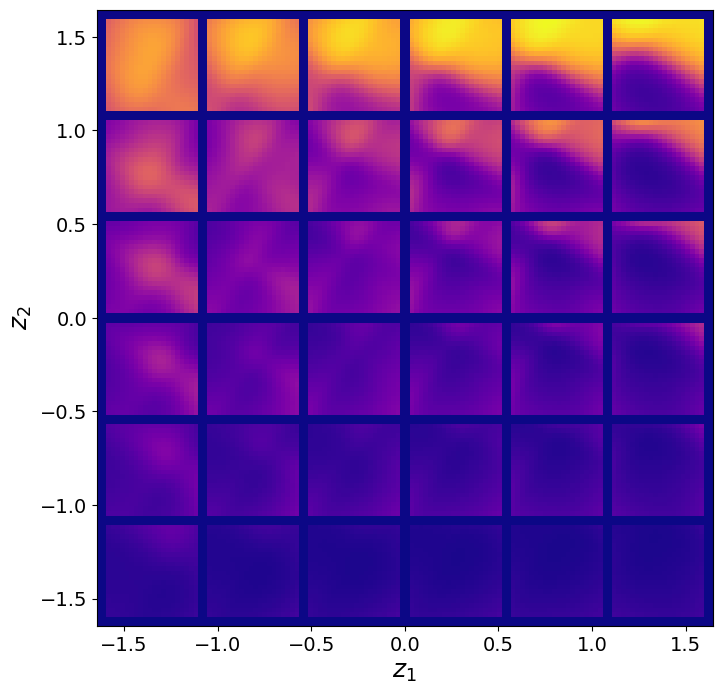

In [ ]:
rvae_EI.manifold2d(6,
                   # z_coord = [z_mean_EI[:, -1].min(), z_mean_EI[:, -1].max(), z_mean_EI[:, -2].min(), z_mean_EI[:, -2].max()],
                   cmap = 'plasma', dpi = 100);

Maximum uncertainty sampled data

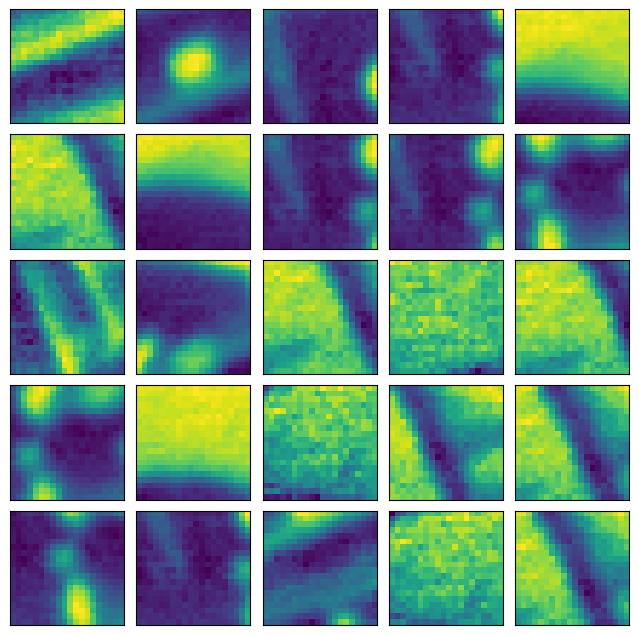

In [ ]:
# Load DKL sampled data
os.chdir(rf + acq_funcs[1] + save_explore)
rec = np.load("final_traindata.npz")
X_train = rec['X_train']

# Initialize VAE train loader
vae_MU_data = torch.tensor(X_train.reshape(-1, ws, ws)).float()
vae_MU_loader = pv.utils.init_dataloader(vae_MU_data, batch_size=64, device = 'cuda')

np.random.seed(1)
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for ax in axes.flat:
    i = np.random.randint(len(vae_MU_data))
    ax.imshow(vae_MU_data[i].cpu(), interpolation='nearest')

In [ ]:
# train VAE using the constructed stack of subimages
in_dim = (ws, ws)
rvae_MU = pv.models.iVAE(in_dim, latent_dim=2, invariances='r',
                      sampler_d='gaussian', decoder_sig=0.01, seed=42)
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae_MU)

# Train for n epochs:
for e in range(200):
    trainer.step(vae_MU_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: 205764.0114
Epoch: 2 Training loss: 160183.4251
Epoch: 3 Training loss: 125471.7390
Epoch: 4 Training loss: 81968.1546
Epoch: 5 Training loss: 58993.5739
Epoch: 6 Training loss: 65537.4353
Epoch: 7 Training loss: 74469.9527
Epoch: 8 Training loss: 61165.4232
Epoch: 9 Training loss: 51250.8462
Epoch: 10 Training loss: 45850.9273
Epoch: 11 Training loss: 46869.4460
Epoch: 12 Training loss: 45938.8902
Epoch: 13 Training loss: 43938.4492
Epoch: 14 Training loss: 42663.2131
Epoch: 15 Training loss: 44033.4692
Epoch: 16 Training loss: 39933.4832
Epoch: 17 Training loss: 39822.6894
Epoch: 18 Training loss: 39453.0435
Epoch: 19 Training loss: 38739.0126
Epoch: 20 Training loss: 38248.3063
Epoch: 21 Training loss: 36521.3806
Epoch: 22 Training loss: 34775.1725
Epoch: 23 Training loss: 34848.1873
Epoch: 24 Training loss: 34891.5069
Epoch: 25 Training loss: 34122.5669
Epoch: 26 Training loss: 33798.5900
Epoch: 27 Training loss: 35282.4409
Epoch: 28 Training loss: 36154.699

Text(0, 0.5, '$z_1$')

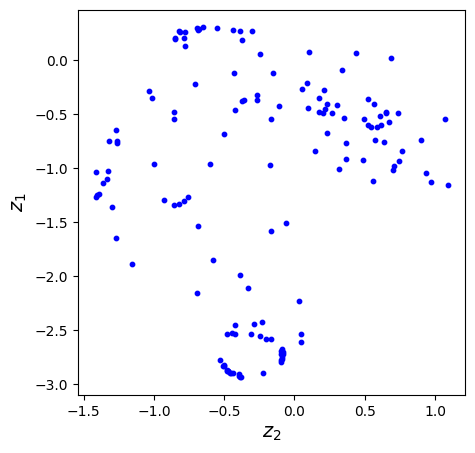

In [ ]:
z_mean_MU, z_sd_MU = rvae_MU.encode(vae_MU_data)

plt.figure(figsize=(5, 5), dpi = 100)
plt.scatter(z_mean_MU[:, -1], z_mean_MU[:, -2], s=10, c='blue')
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$z_1$", fontsize=14)

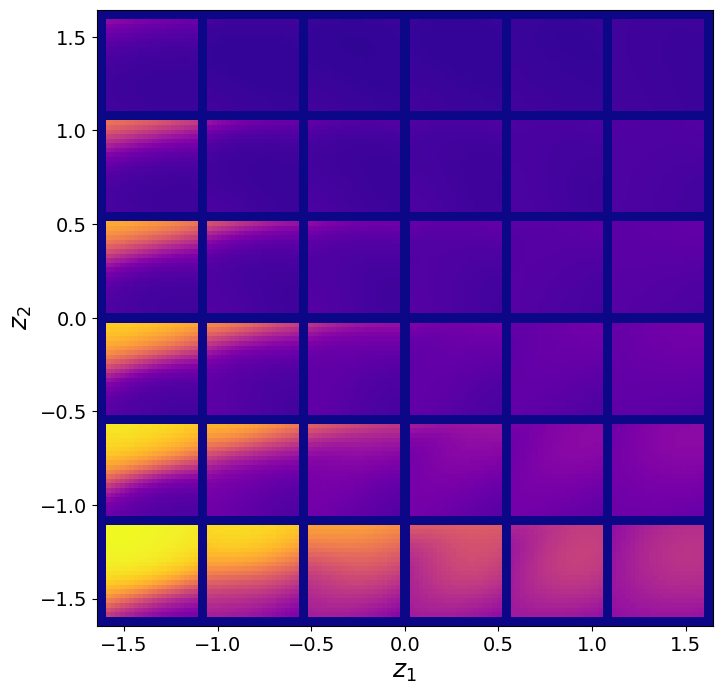

In [ ]:
rvae_MU.manifold2d(6,
                   # z_coord = [z_mean_MU[:, -1].min(), z_mean_MU[:, -1].max(), z_mean_MU[:, -2].min(), z_mean_MU[:, -2].max()],
                   cmap = 'plasma', dpi = 100);

And finally UCB sampled data

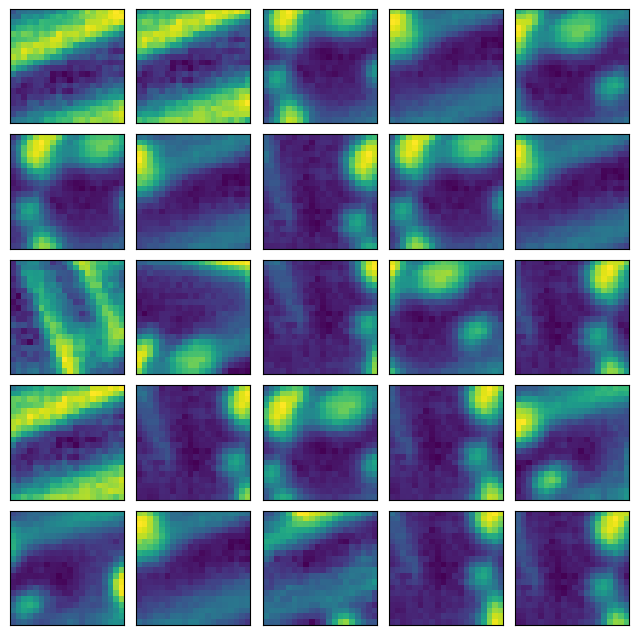

In [ ]:
# Load DKL sampled data
os.chdir(rf + acq_funcs[2] + save_explore)
rec = np.load("final_traindata.npz")
X_train = rec['X_train']

# Initialize VAE train loader
vae_UCB_data = torch.tensor(X_train.reshape(-1, ws, ws)).float()
vae_UCB_loader = pv.utils.init_dataloader(vae_UCB_data, batch_size=64, device = 'cuda')

np.random.seed(1)
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for ax in axes.flat:
    i = np.random.randint(len(vae_UCB_data))
    ax.imshow(vae_UCB_data[i].cpu(), interpolation='nearest')

In [ ]:
# train VAE using the constructed stack of subimages
in_dim = (ws, ws)
rvae_UCB = pv.models.iVAE(in_dim, latent_dim=2, invariances='r',
                      sampler_d='gaussian', decoder_sig=0.01, seed=42)
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae_UCB)

# Train for n epochs:
for e in range(200):
    trainer.step(vae_UCB_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: 196189.9157
Epoch: 2 Training loss: 82183.4607
Epoch: 3 Training loss: 69092.1484
Epoch: 4 Training loss: 63579.7975
Epoch: 5 Training loss: 65854.7828
Epoch: 6 Training loss: 59438.7534
Epoch: 7 Training loss: 56845.5290
Epoch: 8 Training loss: 51324.7877
Epoch: 9 Training loss: 44619.0109
Epoch: 10 Training loss: 39982.5636
Epoch: 11 Training loss: 37751.7049
Epoch: 12 Training loss: 38075.7133
Epoch: 13 Training loss: 39723.3368
Epoch: 14 Training loss: 41947.6721
Epoch: 15 Training loss: 33967.4538
Epoch: 16 Training loss: 32278.4929
Epoch: 17 Training loss: 34585.8258
Epoch: 18 Training loss: 33162.1915
Epoch: 19 Training loss: 31009.8885
Epoch: 20 Training loss: 30936.4822
Epoch: 21 Training loss: 31264.5929
Epoch: 22 Training loss: 30492.2339
Epoch: 23 Training loss: 29878.2718
Epoch: 24 Training loss: 29255.3580
Epoch: 25 Training loss: 28786.0090
Epoch: 26 Training loss: 28577.5338
Epoch: 27 Training loss: 28197.2417
Epoch: 28 Training loss: 28026.6489


Text(0, 0.5, '$z_1$')

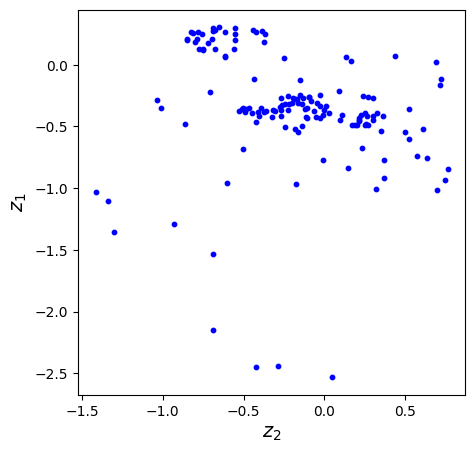

In [ ]:
z_mean_UCB, z_sd_UCB = rvae_MU.encode(vae_UCB_data)

plt.figure(figsize=(5, 5), dpi = 100)
plt.scatter(z_mean_UCB[:, -1], z_mean_UCB[:, -2], s=10, c='blue')
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$z_1$", fontsize=14)

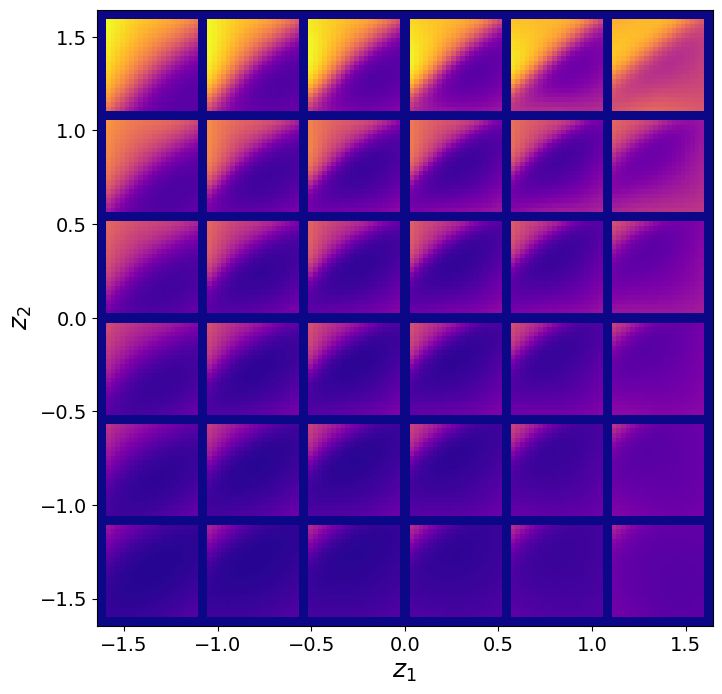

In [ ]:
rvae_UCB.manifold2d(6,
                    # z_coord = [z_mean_UCB[:, -1].min(), z_mean_UCB[:, -1].max(), z_mean_UCB[:, -2].min(), z_mean_UCB[:, -2].max()],
                    cmap = 'plasma', dpi = 100);

## Latent trajectory analysis

Here, we analyze the feature space (i.e. latent space) of the full set of image patches, and plot the AE trajectories in this latent space.

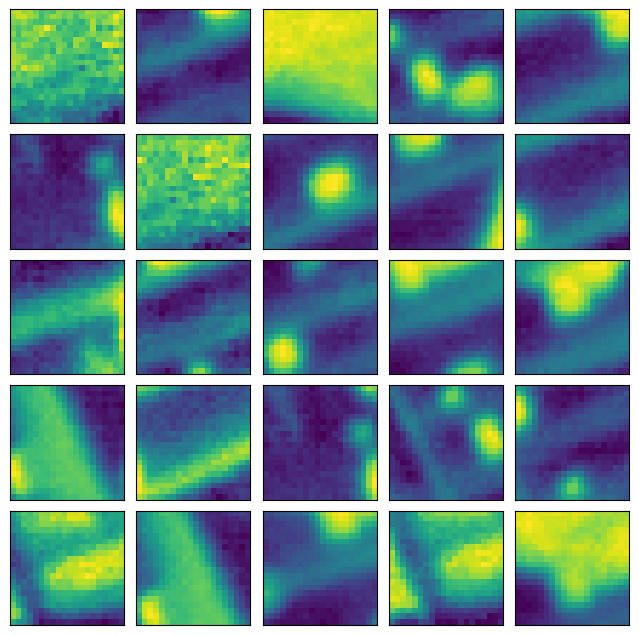

In [ ]:
# Initialize VAE train loader
vae_all_data = torch.tensor(X.reshape(-1, ws, ws)).float()
vae_all_loader = pv.utils.init_dataloader(vae_all_data, batch_size=64, device = 'cuda')

np.random.seed(1)
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for ax in axes.flat:
    i = np.random.randint(len(vae_all_data))
    ax.imshow(vae_all_data[i].cpu(), interpolation='nearest')

In [ ]:
# train VAE using the constructed stack of subimages
in_dim = (ws, ws)
rvae_all = pv.models.iVAE(in_dim, latent_dim=2, invariances='r',
                      sampler_d='gaussian', decoder_sig=0.01, seed=42)
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae_all)

# Train for n epochs:
for e in range(200):
    trainer.step(vae_all_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: 40358.3070
Epoch: 2 Training loss: 21914.6364
Epoch: 3 Training loss: 19763.4397
Epoch: 4 Training loss: 18900.3709
Epoch: 5 Training loss: 18758.4558
Epoch: 6 Training loss: 17653.8400


KeyboardInterrupt: ignored

In [ ]:
z_mean_all, z_sd_all = rvae_all.encode(vae_all_data)

plt.figure(figsize=(5, 5), dpi = 100)
plt.title('all data')
plt.scatter(z_mean_all[:, -1], z_mean_all[:, -2], s=10, c='blue')
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$z_1$", fontsize=14)

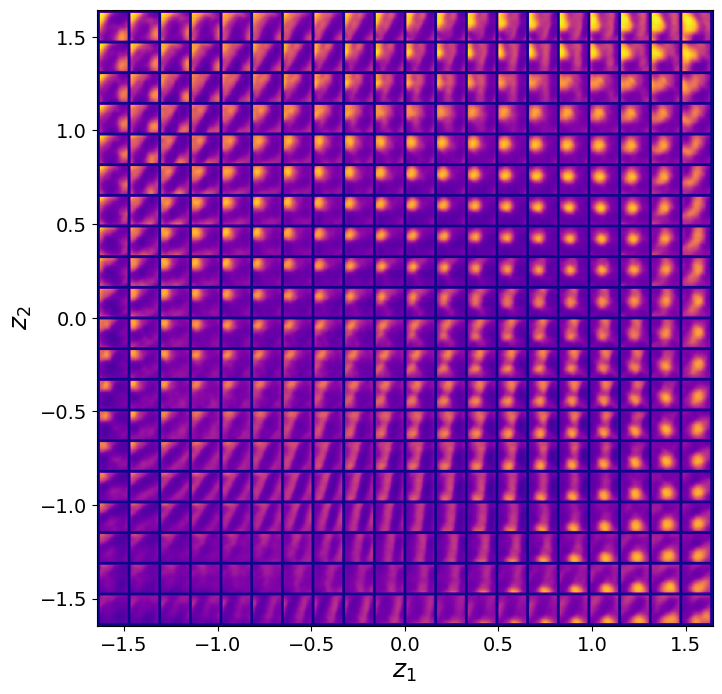

In [ ]:
rvae_all.manifold2d(20,
                    #z_coord = [z_mean_all[:, -1].min(), z_mean_all[:, -1].max(), z_mean_all[:, -2].min(), z_mean_all[:, -2].max()],
                    cmap = 'plasma', dpi = 300);

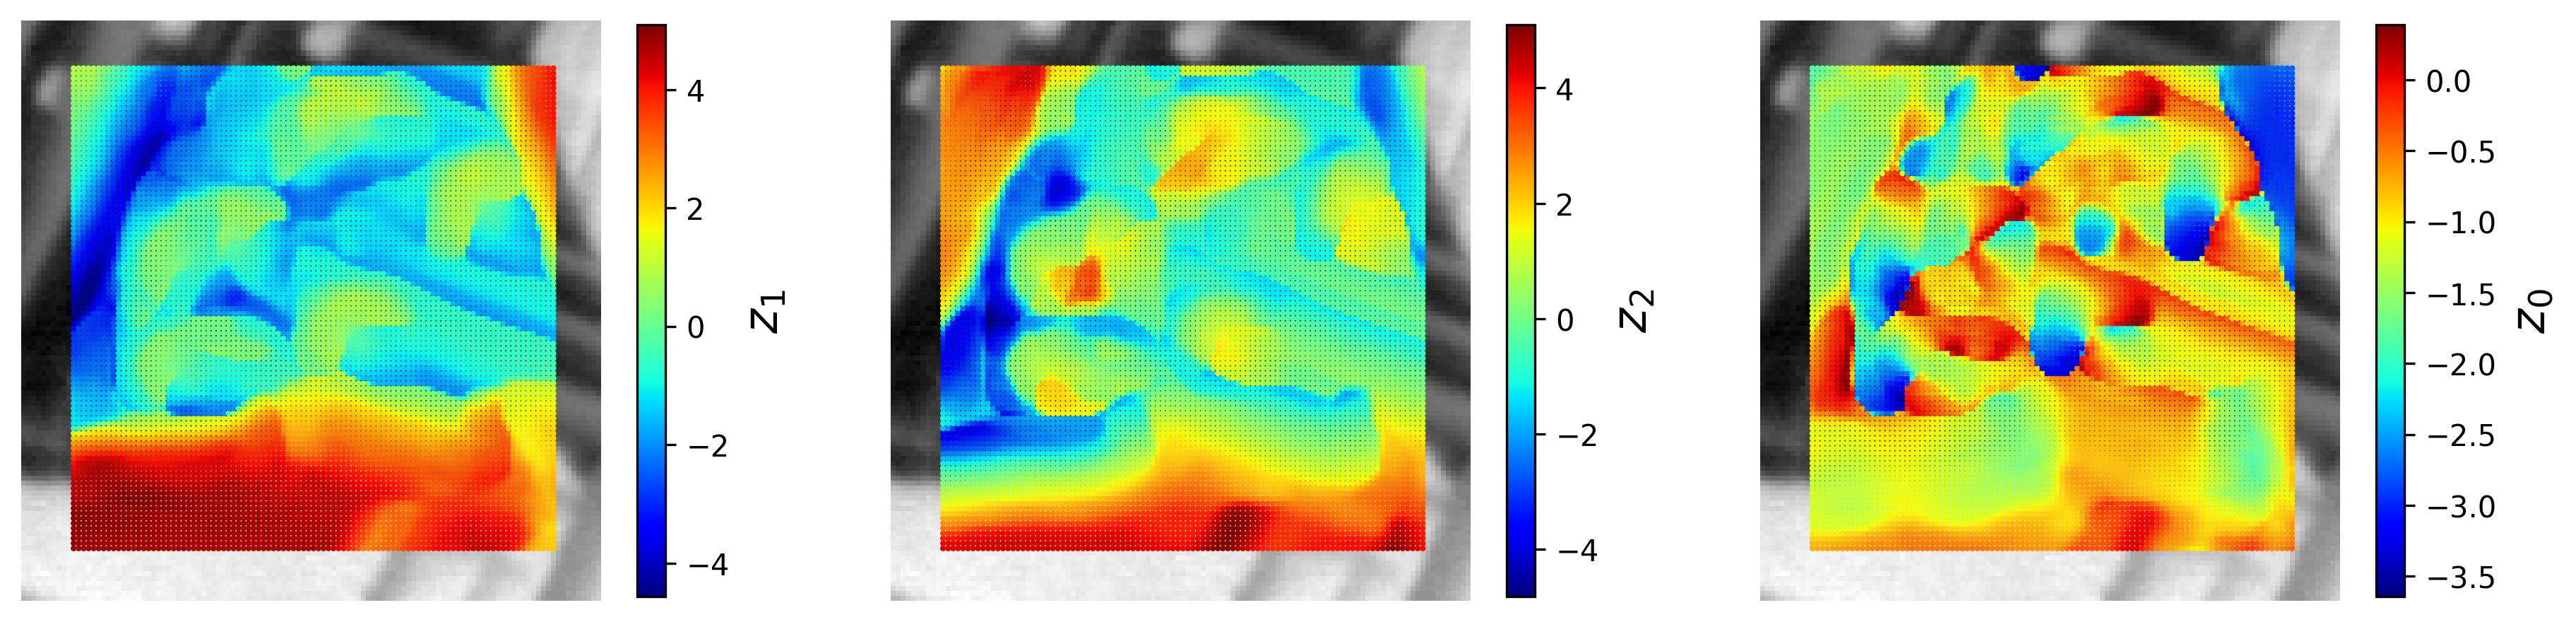

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi = 300)
ax1.imshow(full_img, origin = "lower", cmap = 'gray')
im1=ax1.scatter(indices_all[:,1], indices_all[:,0], s=1, c = z_mean_all[:,-2], cmap = 'jet')
ax1.axis(False)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.7)
cbar1.set_label("$z_1$", fontsize=16)

ax2.imshow(full_img, origin = "lower", cmap = 'gray')
im2=ax2.scatter(indices_all[:,1], indices_all[:,0], s=1, c = z_mean_all[:,-1], cmap = 'jet')
ax2.axis(False)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.7)
cbar2.set_label("$z_2$", fontsize=16)

im3=ax3.imshow(full_img, origin = "lower", cmap = 'gray')
im3=ax3.scatter(indices_all[:,1], indices_all[:,0], s=1, c = z_mean_all[:,-3], cmap = 'jet')
ax3.axis(False)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.7)
cbar3.set_label("$z_0$", fontsize=16)

Plot samplings (from different acquition functions) distribution in the latent space of all patches

In [ ]:
import pandas as pd
import seaborn as sns

z1 = np.asarray(z_mean_all, dtype = np.float32);
z2 = np.asarray(z_mean_EI, dtype = np.float32)
d = np.append(z1, z2, axis = 0)

s = pd.DataFrame({"z0": d[:,0], "z1": d[:,1], "z2": d[:,2]})

#, "Data": 'All Data'})
#s['Data'][len(z1):] = "DKL Train Data"

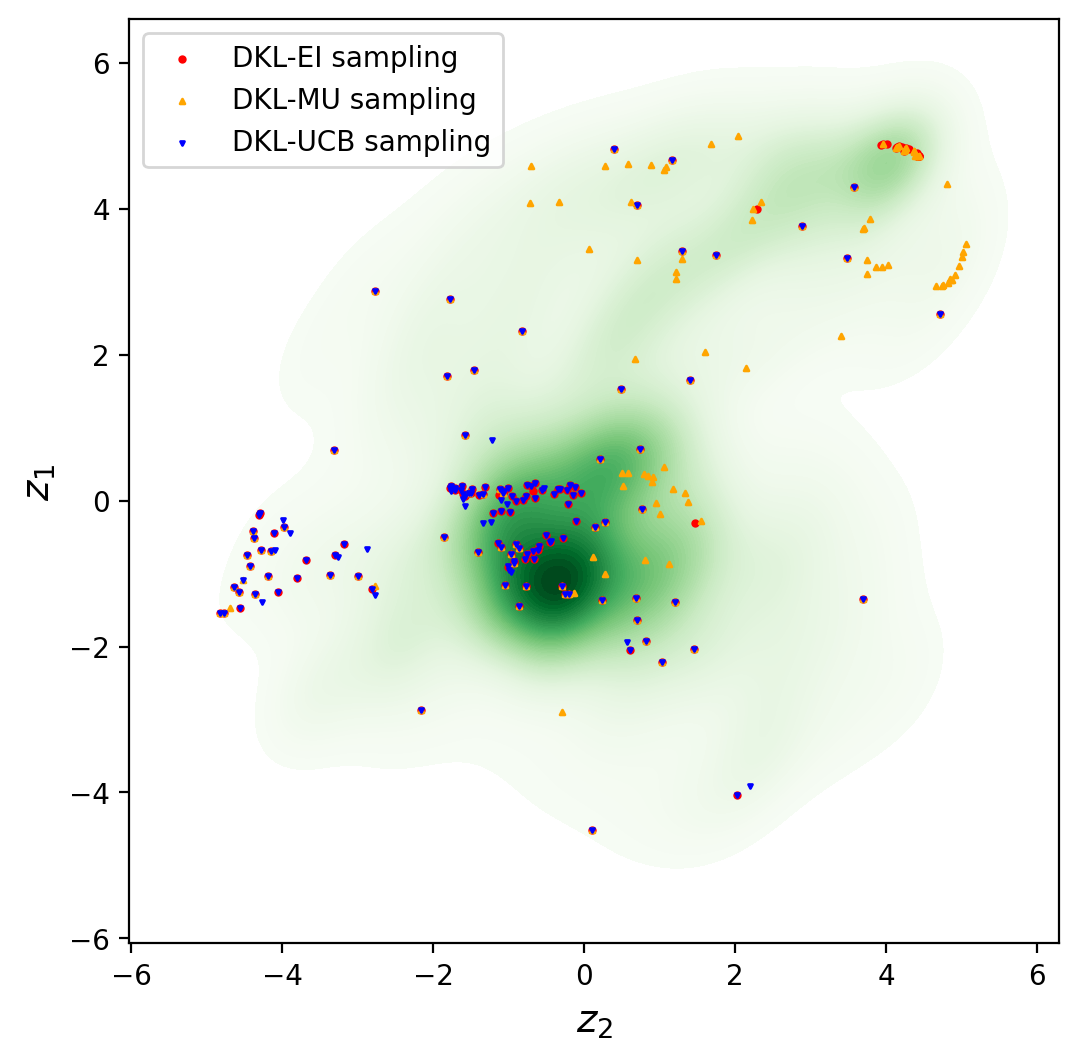

In [ ]:
z_mean_all_EI, z_sd_all_EI = rvae_all.encode(vae_EI_data)
z_mean_all_MU, z_sd_all_MU = rvae_all.encode(vae_MU_data)
z_mean_all_UCB, z_sd_all_UCB = rvae_all.encode(vae_UCB_data)

f, ax = plt.subplots(figsize = (6,6), dpi = 200)

#data = z1
#s = pd.DataFrame({"z0": data[:,0], "z1": data[:,1], "z2": data[:,2]})
ax = sns.kdeplot(data=s, x = "z2", y = "z1", fill=True, thresh=0.01, levels=100, cmap="Greens")
# ax.set_ylim(-5, 5)
# ax.set_xlim(-5, 5)

#ax.scatter(z_mean_all[:, -1], z_mean_all[:, -2], c = 'gray', s=0.5, label = "Full patches")
ax.scatter(z_mean_all_EI[:, -1], z_mean_all_EI[:, -2], c='r', marker = 'o', s=4, label = "DKL-EI sampling")
ax.scatter(z_mean_all_MU[:, -1], z_mean_all_MU[:, -2], c='orange', marker = '^', s=3, label = "DKL-MU sampling")
ax.scatter(z_mean_all_UCB[:, -1], z_mean_all_UCB[:, -2], c='blue', marker = 'v', s=2, label = "DKL-UCB sampling")
ax.set_xlabel("$z_2$", fontsize=14)
ax.set_ylabel("$z_1$", fontsize=14)

ax.legend()

# Summary and definitions

Summary of the definitions for forensic descriptors.

- **Global image:** Initial structural data set available before DKL experiment. Used to create patches for DKL training

- **DKL latents:**	The latent variables encoding the structural information in the patches

- **Scalarizer function:**	Function defining what characteristic of spectrum guides Bayesian Optimization

- **Acquisition function:**	Function combining DKL prediction and uncertainty of the scalarizer function

- **Policy:**	Principle for selection of next path. Simplest policy is maximization of **acquisition function**, but can be more complex including epsilon-greedy or switch between multiple scalarizers or acquisition functions. Human in the loop intervention tunes some aspect of the policy

- **Experimental trace:**	Collection of patches (and their coordinates) and spectra derived during experiment. Trace and global image are the results of AE microscopy.

- **Live DKL model:**	DKL model in the state corresponding to the n-th experimental step

- **Final DKL model:**	DKL model in the state corresponding to the end of the experiment

- **Complete DKL model:**	DKL model trained on the full data set (if available from grid measurements, etc).

- **Regret analysis:**	The difference between predictions of live DKL model and final DKL model after the whole experiment (i.e., after 200 steps in this work)

- **Learning curve:**	Change of the DKL uncertainty (mean and deviation), indicative of the predictability of the patch-scalarizer relationship

- **Counterfactual scalarizer:**	The availability of full spectral data as a part of experimental trace allows to estimate what the BO step would be if scalarizer were chosen to be different

- **Trajectory analysis:**	Real-time trajectory of the probe that can be represented in the global image plane

- **Feature discovery:**	Analysis of the latent variables and latent representations of image patches and spectra in the trace. Here, we realize only patch analysis but extension to spectra is straightforward.

- **Latent trajectory analysis:** 	Analysis of the experimental trajectory in the latent space of the full collection of the image patches derived from the global image
